In [32]:
# Import relevant libraries
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings
import seaborn

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import statistics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

# packages that are used inside sklearn

from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr, spearmanr
import networkx as nx


from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim

In [33]:
# Read in data
macro = pd.read_excel('macro data.xlsx')
price = pd.read_excel('price data.xlsx')
merged_df = pd.merge(price, macro, on='Date', how='left')
price.drop(columns=['000979.CSI', 'GC.CMX', 'SI.CMX', 'HG.CMX', 'PL.NYM', 'PA.NYM'], inplace=True)

# Display the first few rows of the merged dataframe
print(merged_df.head())

        Date  000979.CSI  GC.CMX  SI.CMX  HG.CMX  PL.NYM  PA.NYM  CU.SHF  \
0 2014-01-02    2823.299  1222.4  20.000  3.3860  1401.9  729.70   52670   
1 2014-01-03    2795.280  1237.4  20.135  3.3525  1413.1  727.50   51920   
2 2014-01-06    2702.535  1236.9  20.160  3.3580  1417.9  738.75   51770   
3 2014-01-07    2701.617  1230.9  19.835  3.3470  1416.8  742.20   51860   
4 2014-01-08    2678.524  1225.0  19.510  3.3505  1417.6  736.55   52060   

   AL.SHF  ZN.SHF  ...  PP.DCE  EG.DCE  PG.DCE  LH.DCE          GDP   PPI  \
0   14040   15300  ...     NaN     NaN     NaN     NaN  1378.141111 -1.64   
1   13995   15120  ...     NaN     NaN     NaN     NaN  1378.141111 -1.64   
2   13905   15000  ...     NaN     NaN     NaN     NaN  1378.141111 -1.64   
3   13910   15050  ...     NaN     NaN     NaN     NaN  1378.141111 -1.64   
4   13850   15075  ...     NaN     NaN     NaN     NaN  1378.141111 -1.64   

      CPI    CCPI  LPR-5  LPR-1  
0  2.4861  141.08    NaN   5.73  
1  2.4861  1

In [34]:
# Data for the baseline model
price['Date'] = pd.to_datetime(price['Date'], errors='coerce')
price.set_index('Date', inplace=True)
# Remove columns with more than 1000 NaN values
columns_to_remove_price = price.columns[price.isna().sum() > 1000]
cleaned_price = price.drop(columns=columns_to_remove_price)

# Fill remaining NaN values with the mean of the column
filled_price = cleaned_price.fillna(cleaned_price.mean())
print(filled_price.head())


            CU.SHF  AL.SHF  ZN.SHF  PB.SHF         NI.SHF         SN.SHF  \
Date                                                                       
2014-01-02   52670   14040   15300   14345  119649.433255  165284.562061   
2014-01-03   51920   13995   15120   14200  119649.433255  165284.562061   
2014-01-06   51770   13905   15000   14105  119649.433255  165284.562061   
2014-01-07   51860   13910   15050   14150  119649.433255  165284.562061   
2014-01-08   52060   13850   15075   14140  119649.433255  165284.562061   

            AU.SHF  AG.SHF  RU.SHF  FU.SHF  ...  B.DCE  M.DCE  Y.DCE  P.DCE  \
Date                                        ...                               
2014-01-02  244.45    4213   18135    4482  ...   3975   3354   6922   6148   
2014-01-03  246.40    4213   17625    4480  ...   3969   3338   6822   6068   
2014-01-06  246.90    4194   17245    4480  ...   3975   3343   6696   5976   
2014-01-07  246.95    4193   16815    4480  ...   4015   3284   6612   5

In [35]:
# last 20% of data
num_rows = int(len(filled_price) * 0.2)
filled_price_20 = filled_price.tail(num_rows)
print(filled_price_20)

            CU.SHF  AL.SHF  ZN.SHF  PB.SHF    NI.SHF    SN.SHF  AU.SHF  \
Date                                                                     
2021-12-30   70010   20460   24165   15325  150450.0  294370.0  370.80   
2021-12-31   70380   20380   24125   15300  152080.0  296110.0  374.70   
2022-01-04   69730   20210   24050   15385  152570.0  289950.0  371.74   
2022-01-05   70110   20380   24415   15200  152160.0  295520.0  373.10   
2022-01-06   69490   20685   24385   15060  149930.0  295350.0  370.64   
...            ...     ...     ...     ...       ...       ...     ...   
2023-12-25   69080   19110   21315   15720  130900.0  209440.0  480.80   
2023-12-26   69330   19235   21440   15745  129140.0  208780.0  481.40   
2023-12-27   69260   19325   21455   15840  129550.0  213910.0  482.60   
2023-12-28   69340   19520   21530   15900  129510.0  212980.0  483.60   
2023-12-29   68920   19505   21545   15875  125210.0  212100.0  481.70   

            AG.SHF  RU.SHF  FU.SHF  .

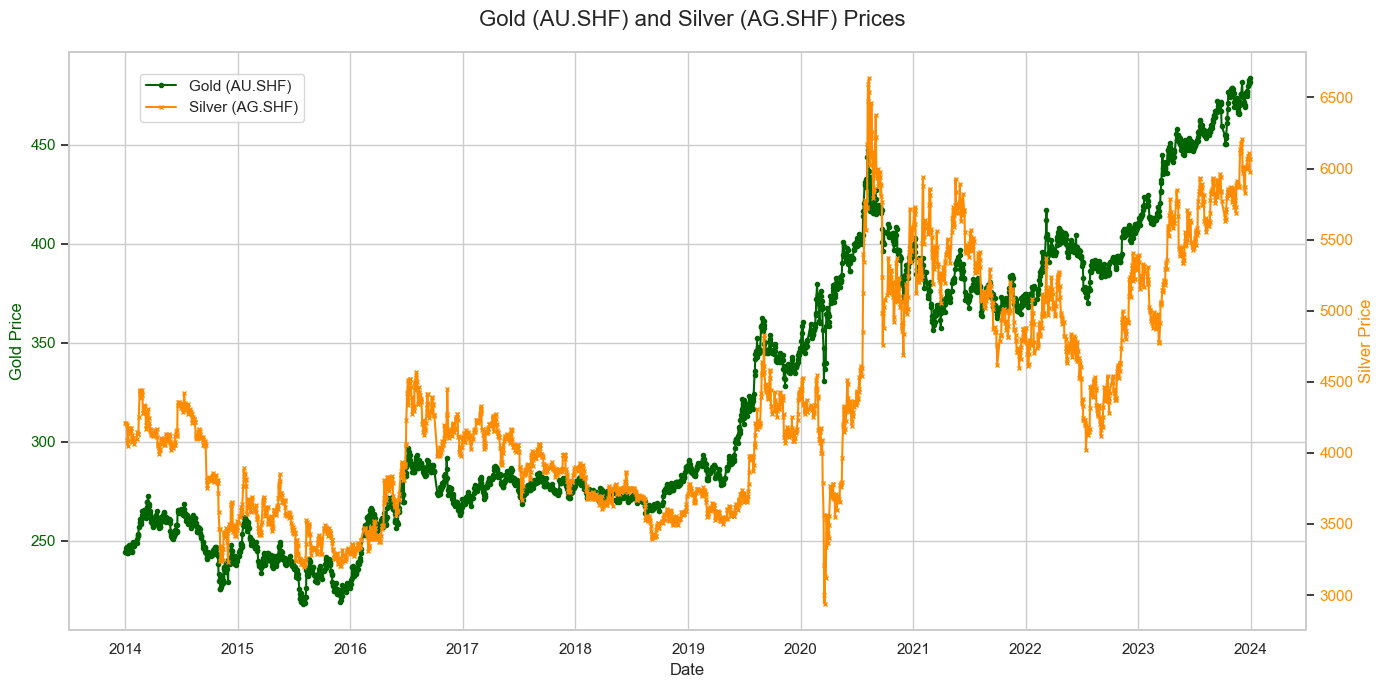

In [37]:
# Plotting Gold and Silver prices
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(filled_price.index, filled_price['AU.SHF'], label='Gold (AU.SHF)', color='darkgreen', marker='o', markersize=3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price', color='darkgreen')
ax1.tick_params(axis='y', labelcolor='darkgreen')
ax1.grid(True)  # Set grid on ax1

ax2 = ax1.twinx()
ax2.plot(filled_price.index, filled_price['AG.SHF'], label='Silver (AG.SHF)', color='darkorange', marker='x', markersize=3)
ax2.set_ylabel('Silver Price', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.grid(False)  # Optionally set grid on ax2

fig.suptitle('Gold (AU.SHF) and Silver (AG.SHF) Prices', fontsize=16)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
fig.tight_layout()
plt.show()

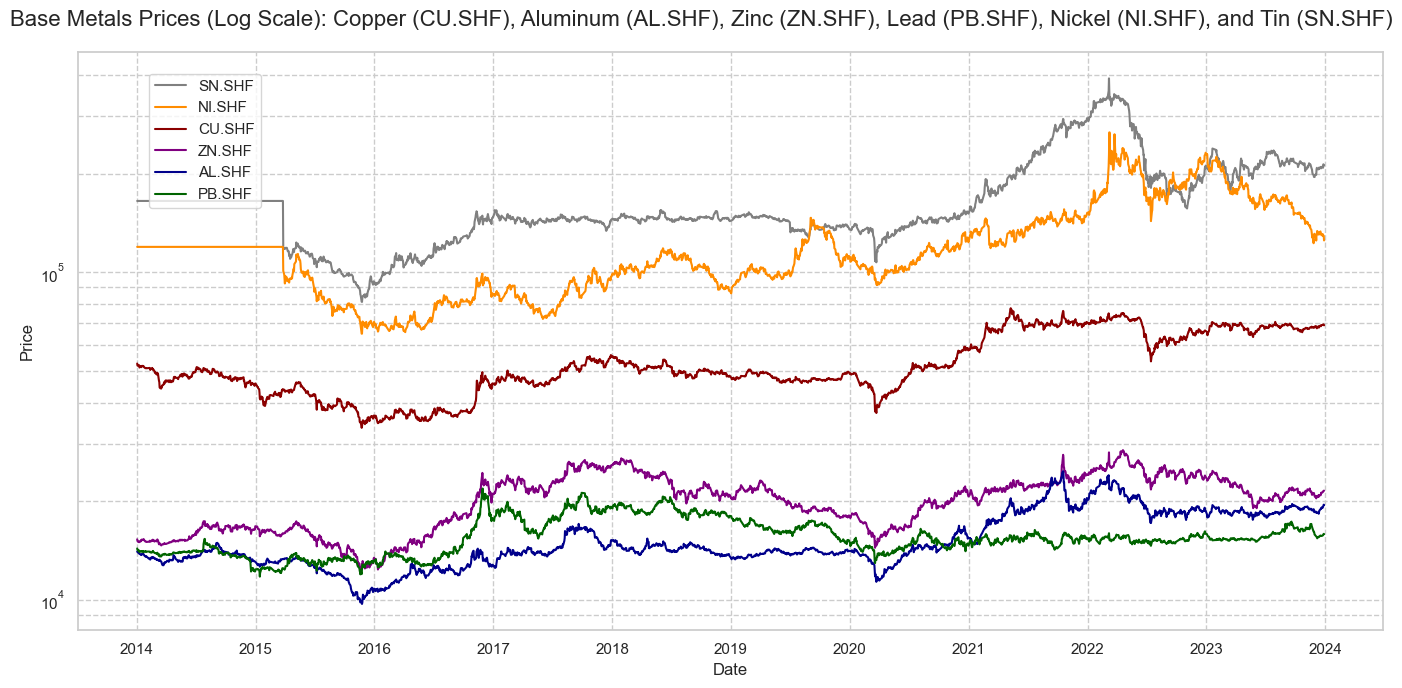

In [191]:
# Plotting the base metals together on the same graph with logarithmic scale
fig, ax1 = plt.subplots(figsize=(14, 7))

colors = {
    'SN.SHF': 'grey',
    'NI.SHF': 'darkorange',
    'CU.SHF': 'darkred',
    'ZN.SHF': 'purple',
    'AL.SHF': 'darkblue',    
    'PB.SHF': 'darkgreen'
    
}

# Plot each commodity with its respective color
for commodity, color in colors.items():
    ax1.plot(filled_price.index, filled_price[commodity], label=f'{commodity}', color=color)

ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.set_yscale('log')  # Apply logarithmic scale to the y-axis
ax1.grid(True, which="both", ls="--")  # Set grid on ax1 with dashed lines

fig.suptitle('Base Metals Prices (Log Scale): Copper (CU.SHF), Aluminum (AL.SHF), Zinc (ZN.SHF), Lead (PB.SHF), Nickel (NI.SHF), and Tin (SN.SHF)', fontsize=16)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
fig.tight_layout()
plt.show()

Using a linear scale would make it hard to see the variations and trends in the prices of lead and aluminum if they are plotted on the same graph as tin. A logarithmic scale helps to compress the range and makes it possible to see the relative changes and trends in all the commodities on the same plot.

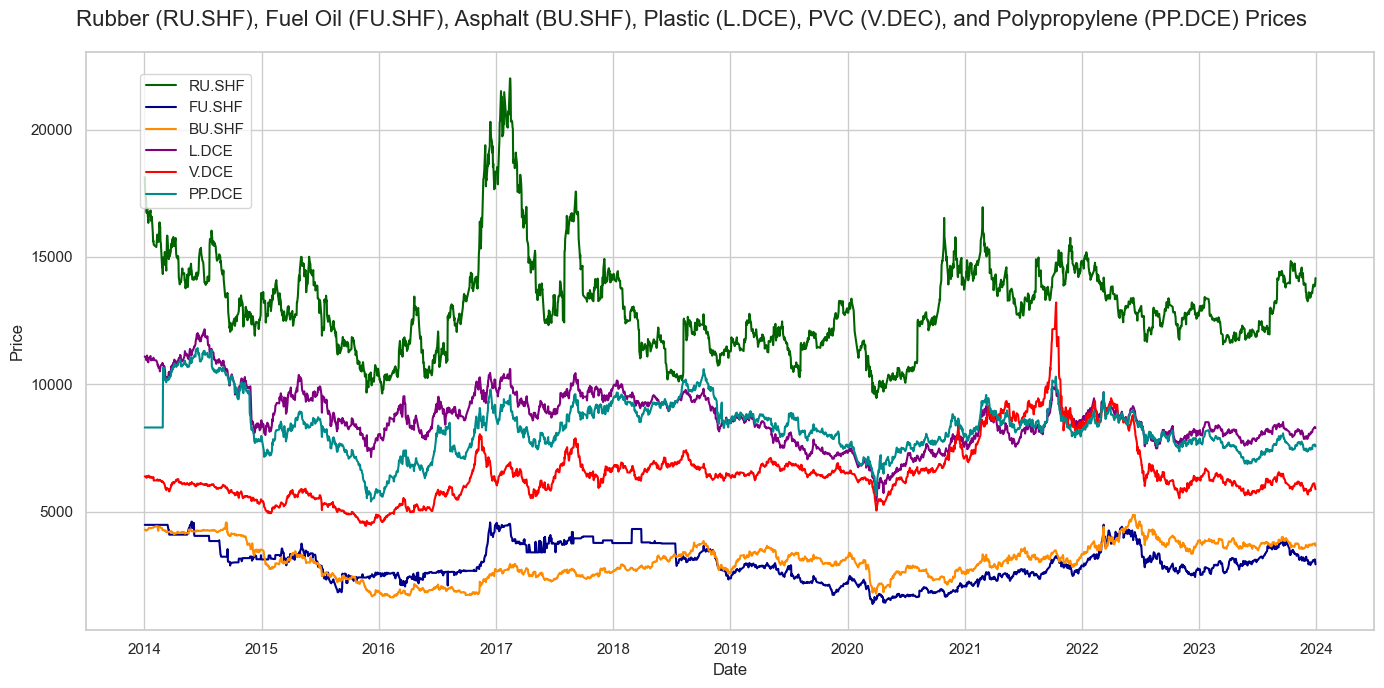

In [192]:
# Plotting the commodities together on the same graph
fig, ax1 = plt.subplots(figsize=(14, 7))


colors = {
    'RU.SHF': 'darkgreen',
    'FU.SHF': 'darkblue',
    'BU.SHF': 'darkorange',
    'L.DCE': 'purple',
    'V.DCE': 'red',
    'PP.DCE': 'darkcyan'
}

# Plot each commodity with its respective color
for commodity, color in colors.items():
    ax1.plot(filled_price.index, filled_price[commodity], label=f'{commodity}', color=color)

ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True)  # Set grid on ax1

fig.suptitle('Rubber (RU.SHF), Fuel Oil (FU.SHF), and Asphalt (BU.SHF) Prices', fontsize=16)
fig.suptitle('Rubber (RU.SHF), Fuel Oil (FU.SHF), Asphalt (BU.SHF), Plastic (L.DCE), PVC (V.DEC), and Polypropylene (PP.DCE) Prices', fontsize=16)

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
fig.tight_layout()
plt.show()


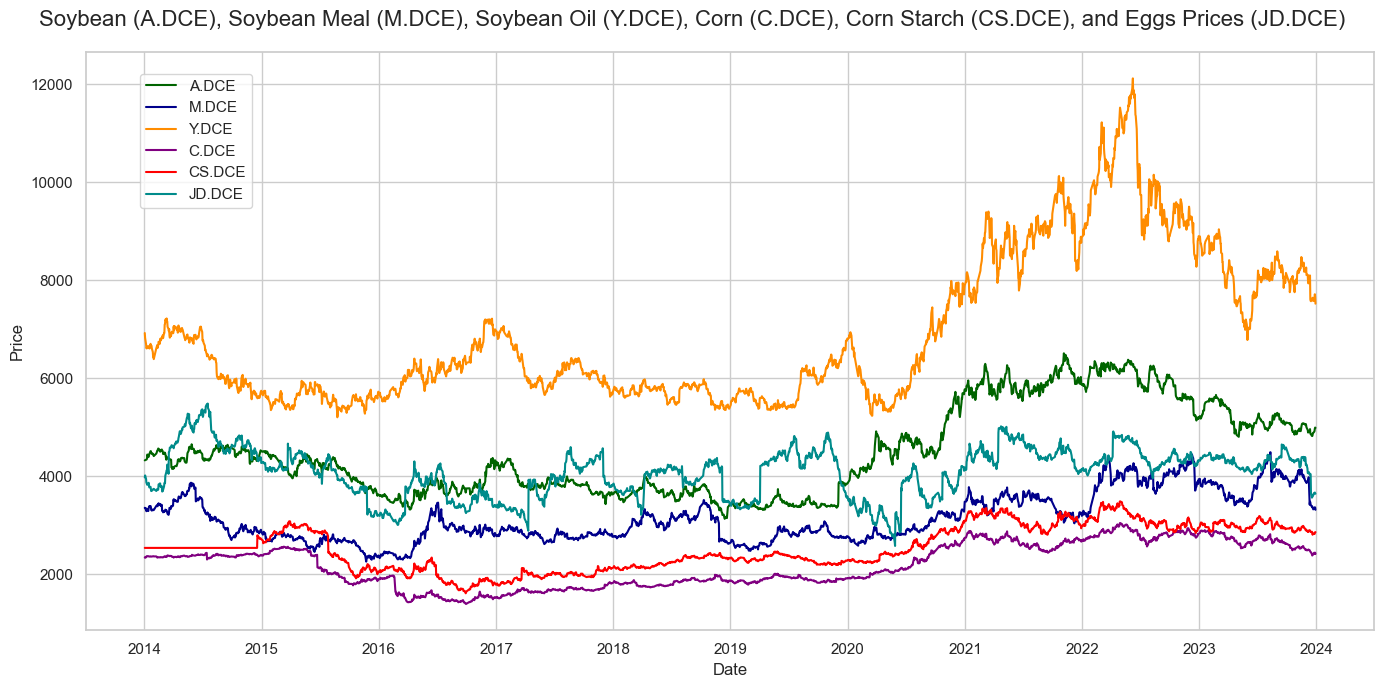

In [41]:
# Plotting the selected commodities together on the same graph
fig, ax1 = plt.subplots(figsize=(14, 7))

colors = {
    'A.DCE': 'darkgreen',  # Soybean
    'M.DCE': 'darkblue',   # Soybean Meal
    'Y.DCE': 'darkorange', # Soybean Oil
    'C.DCE': 'purple',     # Corn
    'CS.DCE': 'red',       # Corn Starch
    'JD.DCE': 'darkcyan'   # Eggs
}

# Plot each commodity with its respective color
for commodity, color in colors.items():
    ax1.plot(filled_price.index, filled_price[commodity], label=f'{commodity}', color=color)

ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True)  # Set grid on ax1

fig.suptitle('Soybean (A.DCE), Soybean Meal (M.DCE), Soybean Oil (Y.DCE), Corn (C.DCE), Corn Starch (CS.DCE), and Eggs Prices (JD.DCE)', fontsize=16)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
fig.tight_layout()
plt.show()


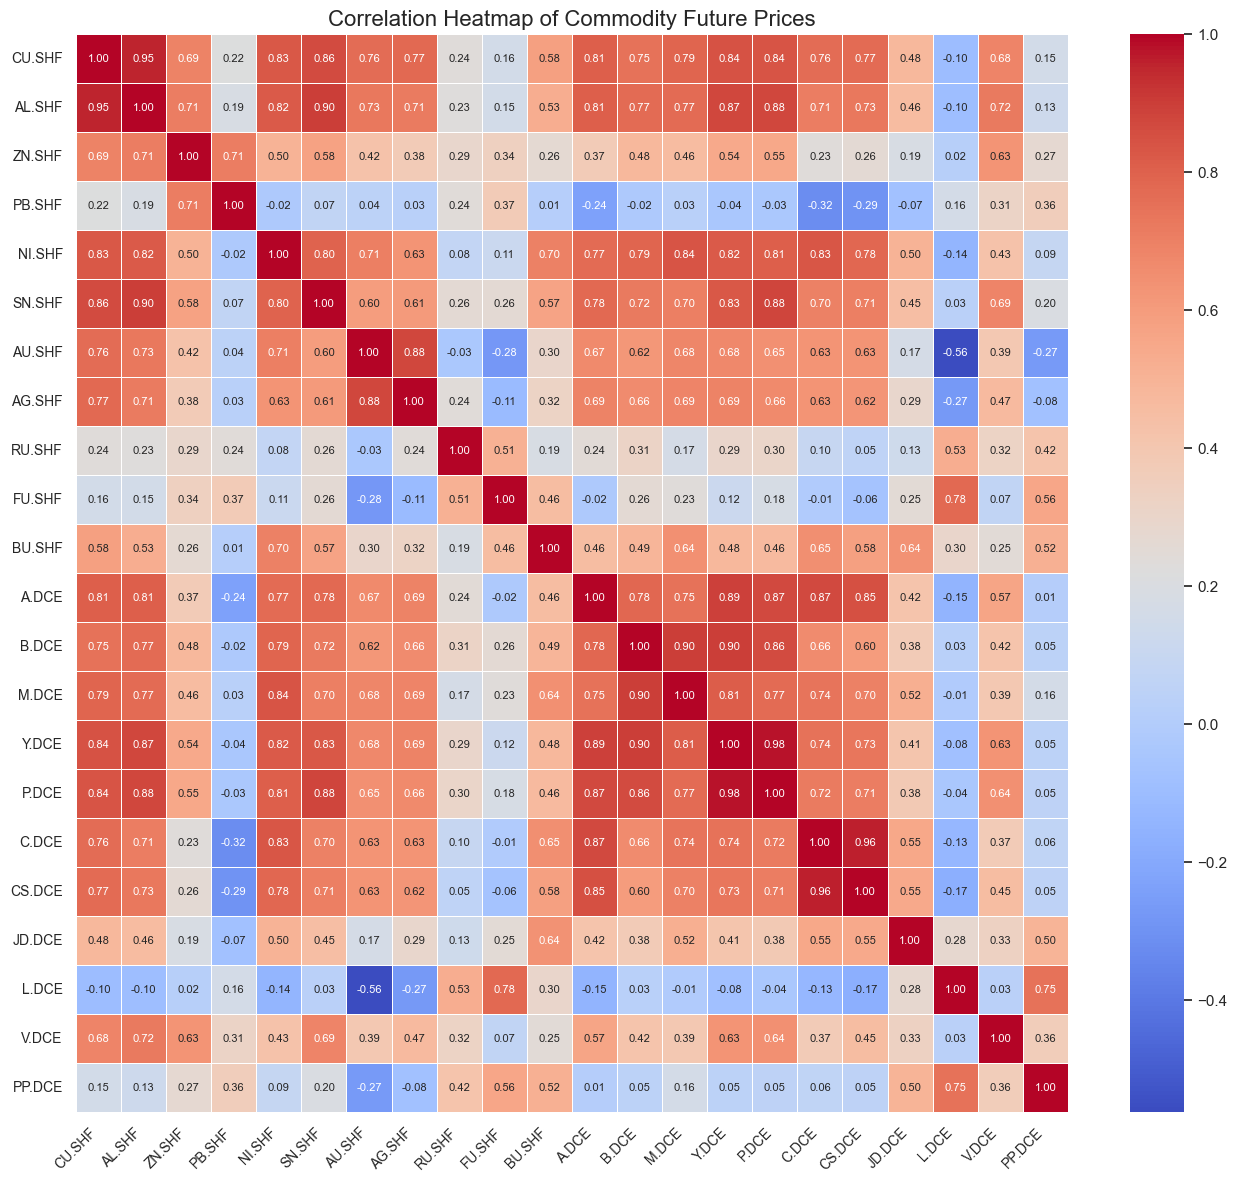

In [209]:
corr_matrix = filled_price.corr()
plt.figure(figsize=(16, 14))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', annot_kws={"size": 8})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Correlation Heatmap of Commodity Future Prices', fontsize=16)
plt.show()


In [43]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [44]:
scores, pvalues, pairs_coint = find_cointegrated_pairs(filled_price)
print(pairs_coint)

[('CU.SHF', 'AL.SHF'), ('AL.SHF', 'SN.SHF'), ('AL.SHF', 'M.DCE'), ('AL.SHF', 'P.DCE'), ('NI.SHF', 'M.DCE'), ('SN.SHF', 'P.DCE'), ('RU.SHF', 'FU.SHF'), ('RU.SHF', 'BU.SHF'), ('RU.SHF', 'A.DCE'), ('RU.SHF', 'B.DCE'), ('RU.SHF', 'M.DCE'), ('RU.SHF', 'Y.DCE'), ('RU.SHF', 'P.DCE'), ('RU.SHF', 'C.DCE'), ('RU.SHF', 'CS.DCE'), ('RU.SHF', 'JD.DCE'), ('RU.SHF', 'L.DCE'), ('RU.SHF', 'V.DCE'), ('RU.SHF', 'PP.DCE'), ('FU.SHF', 'L.DCE'), ('BU.SHF', 'M.DCE'), ('BU.SHF', 'JD.DCE'), ('A.DCE', 'Y.DCE'), ('A.DCE', 'P.DCE'), ('A.DCE', 'CS.DCE'), ('B.DCE', 'M.DCE'), ('B.DCE', 'Y.DCE'), ('B.DCE', 'P.DCE'), ('M.DCE', 'Y.DCE'), ('M.DCE', 'P.DCE'), ('M.DCE', 'C.DCE'), ('M.DCE', 'CS.DCE'), ('Y.DCE', 'P.DCE'), ('C.DCE', 'CS.DCE'), ('JD.DCE', 'L.DCE'), ('JD.DCE', 'V.DCE'), ('JD.DCE', 'PP.DCE')]


In [210]:
df_pairs_coint = pd.DataFrame(pairs_coint, columns=['Commodity 1', 'Commodity 2'])
df_pairs_coint.to_excel('pairs_coint.xlsx', index=False)  # Excel


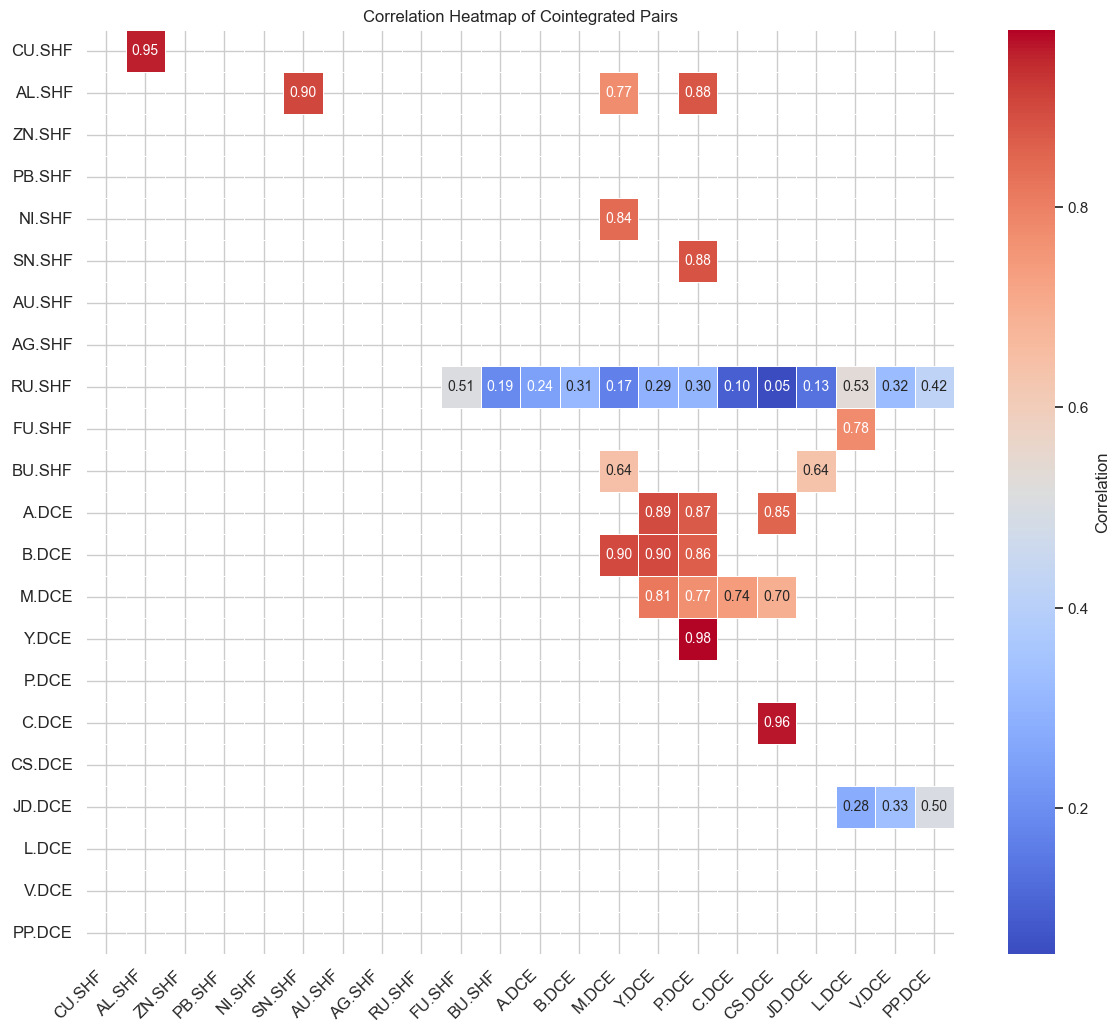

In [45]:
# Create a mask for the non-cointegrated pairs
mask = np.ones_like(pvalues)
mask[pvalues < 0.05] = 0

# Create a masked correlation matrix
masked_corr_matrix = filled_price.corr() * (1 - mask)

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap
sns.heatmap(masked_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', mask=mask, 
            cbar_kws={'label': 'Correlation'}, annot_kws={"size": 10})

# Rotate the x and y labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Remove the grid lines for a cleaner look
#plt.grid(False)

# Add title
plt.title('Correlation Heatmap of Cointegrated Pairs')

# Show the plot
plt.show()

In [46]:
def plot_spread(df, col1, col2, ax):
    S1 = df[col1]
    S2 = df[col2]
    
    # Calculate the spread
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    b = results.params[col1]
    
    spread = S2 - b * df[col1]
    
    # Plot the spread
    spread.plot(ax=ax)
    ax.axhline(spread.mean(), color='black')
    ax.legend([f'Spread between {col1} and {col2}'])
    ax.set_title(f'{col1} vs {col2}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Spread')



In [184]:
def trade(S1, S2, window1, window2):
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std

    # Simulate trading
    portfolio_value = []
    position = False
    money = 0
    countS1 = 0
    countS2 = 0
    position_list = []
    date_list =[]

    for i in range(len(ratios)):
        if position == False:
        # Buy long if the z-score is < -2
            if zscore[i] < - 2:
                money += S1[i] - S2[i] * ratios[i]
                countS1 -= 1
                countS2 += ratios[i]
                position = True
                position_list.append('Long')
                date_list.append(i)

        # Sell short if the z-score is > 2
            elif zscore[i] > 2:
                money -= S1[i] - S2[i] * ratios[i]
                countS1 += 1
                countS2 -= ratios[i]
                position = True
                position_list.append('Short')
                date_list.append(i)

        # Clear positions if the z-score is between -0.5 and 0.5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            position = False
            position_list.append('Exit')
            date_list.append(i)

        # Calculate portfolio value
        portfolio_value.append(money)

    return portfolio_value, position_list, date_list  # Subtract 1 to get the percentage return


In [172]:
def plot_spread_with_signals(full_date_list, full_spread, signal_dates, signal_spread, signals, pair_name):
    plt.figure(figsize=(14, 7))
    
    # Plot the full spread
    plt.plot(full_date_list, full_spread, label='Spread', color='blue')
    
    # Mark signals on the plot
    for i, signal in enumerate(signals):
        if signal == 'Long':
            plt.scatter(signal_dates[i], signal_spread[i], color='green', label='Long' if 'Long' not in plt.gca().get_legend_handles_labels()[1] else "", marker='^', s=100)
        elif signal == 'Short':
            plt.scatter(signal_dates[i], signal_spread[i], color='red', label='Short' if 'Short' not in plt.gca().get_legend_handles_labels()[1] else "", marker='v', s=100)
        elif signal == 'Exit':
            plt.scatter(signal_dates[i], signal_spread[i], color='orange', label='Exit' if 'Exit' not in plt.gca().get_legend_handles_labels()[1] else "", marker='o', s=100)

    plt.title(f'Price Spread with Trading Signals under Mean-reverting Strategy for {pair_name} (2021-2023)')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid(True)
    plt.show()

In [187]:
_, signal_zscore, date_list = trade(filled_price_20['CU.SHF'], filled_price_20['AL.SHF'], 21, 5)


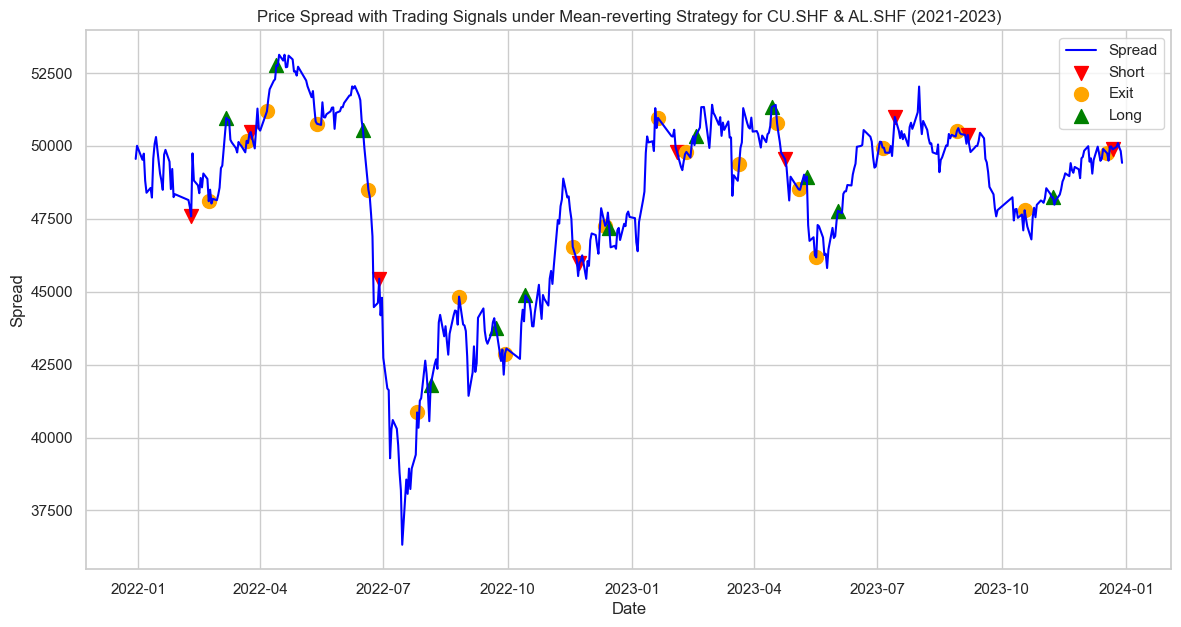

In [247]:
# Full price spread data (replace with your actual data)
full_spread_data = filled_price_20['CU.SHF'] - filled_price_20['AL.SHF']
full_date_list = full_spread_data.index

# Signal data (subset of full data where signals occur)
signal_dates = filled_price_20.iloc[date_list].index
signals = signal_zscore
signal_spread = full_spread_data.loc[signal_dates]

# Plot the full spread with signals marked
plot_spread_with_signals(full_date_list, full_spread_data, signal_dates, signal_spread, signals, 'CU.SHF & AL.SHF')


In [185]:
pair_value_zscore = {}
for pair in pairs_coint:
    value_list, _, _ = trade(filled_price_20[pair[0]], filled_price_20[pair[1]], 21, 5)
    pair_name = f"{pair[0]}_vs_{pair[1]}"

    pair_value_zscore[pair_name] = value_list
    pair_value_zscore_df = pd.DataFrame(pair_value_zscore)



pair_value_zscore_df

,CU.SHF_vs_AL.SHF,AL.SHF_vs_SN.SHF,AL.SHF_vs_M.DCE,AL.SHF_vs_P.DCE,NI.SHF_vs_M.DCE,SN.SHF_vs_P.DCE,RU.SHF_vs_FU.SHF,RU.SHF_vs_BU.SHF,RU.SHF_vs_A.DCE,RU.SHF_vs_B.DCE,...,B.DCE_vs_P.DCE,M.DCE_vs_Y.DCE,M.DCE_vs_P.DCE,M.DCE_vs_C.DCE,M.DCE_vs_CS.DCE,Y.DCE_vs_P.DCE,C.DCE_vs_CS.DCE,JD.DCE_vs_L.DCE,JD.DCE_vs_V.DCE,JD.DCE_vs_PP.DCE
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,9734.193263,-2848.694457,11744.829961,4456.221897,66090.947753,-15228.978879,-826.721502,5564.349213,-944.73878,-877.60614,...,1342.065146,1890.485075,2407.663644,1810.435406,1801.918275,2475.115512,459.037389,2475.570165,1151.259377,2342.227603
482,9734.193263,-2203.970812,11744.829961,4456.221897,66090.947753,-15228.978879,-826.721502,5564.349213,-944.73878,-877.60614,...,1342.065146,1890.485075,2407.663644,1810.435406,1801.918275,2475.115512,459.037389,2475.570165,1151.259377,2342.227603
483,9734.193263,-2203.970812,11744.829961,4456.221897,66090.947753,-15228.978879,-826.721502,5564.349213,-944.73878,-877.60614,...,1342.065146,1890.485075,2407.663644,1810.435406,1801.918275,2475.115512,459.037389,2475.570165,1151.259377,2342.227603
484,9734.193263,-2203.970812,11744.829961,4456.221897,66090.947753,-15228.978879,-826.721502,5564.349213,-944.73878,-877.60614,...,1342.065146,1890.485075,2407.663644,1810.435406,1801.918275,2475.115512,459.037389,2475.570165,1151.259377,2342.227603


In [56]:

def calculate_weighted_portfolio_value(df):

    # Number of columns (pairs)
    num_pairs = df.shape[1]
    
    # Assuming equal weight for each pair
    weights = [1/num_pairs] * num_pairs
    
    # Calculate weighted portfolio value for each row
    portfolio_values = df.dot(weights)
    
    return portfolio_values



In [57]:
def annualized_return(numbers, number_of_years, threshold=1e-10):
    # Find the first non-zero figure above the threshold
    first_nonzero = next((x for x in numbers if abs(x) > threshold), None)
    last_figure = numbers.iloc[-1] if not numbers.empty else None

    if first_nonzero is not None and last_figure is not None:
        total_return = last_figure / first_nonzero - 1
        
        # Handle negative total returns
        if total_return < 0:
            # Calculate the absolute value of the return for exponentiation
            annualized_return = -(abs(1 + total_return) ** (1 / number_of_years) - 1)
        else:
            # Normal case for positive total returns
            annualized_return = (1 + total_return) ** (1 / number_of_years) - 1
            if last_figure < 0 and first_nonzero < 0:
                annualized_return = -annualized_return
            
        return annualized_return
    else:
        print("Insufficient data to calculate return")
        return np.nan


In [58]:
def calculate_percentage_returns(prices):
    if len(prices) < 2:
        return pd.Series([])  # Return an empty Series if prices list is too short
    
    # Initialize list to store percentage returns
    percentage_returns = []

    for i in range(1, len(prices)):
        if prices[i-1] == 0:  # Prevent division by zero
            current_return = 0
        else:
            current_return = (prices[i] - prices[i-1]) / abs(prices[i-1])
        
         #Handle cases with extreme returns
        if abs(current_return) > 10000:  # Example threshold for extreme returns
            current_return = 0  # Consider handling these cases appropriately

        percentage_returns.append(current_return)
    
    return pd.Series(percentage_returns)


In [145]:

def calculate_sharpe_ratio(returns, risk_free_rate=0.0216):
    # Calculate daily returns
    #returns = [(prices[i] / prices[i-1]) - 1 for i in range(1, len(prices))]
    
    # Calculate the mean and standard deviation of returns
    mean_return = np.mean(returns)
    std_dev_return = np.std(returns)
    
    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev_return
    
    return sharpe_ratio


In [244]:
# Calculate weighted portfolio value
portfolio_values_zscore = calculate_weighted_portfolio_value(pair_value_zscore_df)

# Calculate annualized return
annualized_return_zscore = annualized_return(portfolio_values_zscore, 10)

# Calculate percentage returns, handling NaN values
portfolio_returns_zscore = calculate_percentage_returns(portfolio_values_zscore)

# Drop NaN values before calculating volatility
portfolio_returns_zscore = portfolio_returns_zscore.dropna()

# Calculate volatility
volatility_zscore = np.std(portfolio_returns_zscore)

sp_zscore = calculate_sharpe_ratio(portfolio_returns_zscore)

print(f"Portfolio Annualized return: {annualized_return_zscore.round(4)}")
print(f"Volatility: {volatility_zscore.round(4)}")
print(f"Sharpe Ratio: {sp_zscore.round(4)}")




Portfolio Annualized return: 0.9273
Volatility: 0.3633
Sharpe Ratio: 0.0271


In [62]:
def calculate_spread(prices_asset1, prices_asset2):
    return prices_asset1/prices_asset2

def generate_features(spread, lookback):
    X = np.column_stack([spread.shift(i) for i in range(1, lookback + 1)])
    X = X[lookback:]
    y = np.sign(spread.diff().shift(-1)[lookback:])
    y = y.replace(0, np.nan).fillna(method='ffill').fillna(0).astype(int)  # Replace zeros with previous non-zero value
    return X, y

In [63]:
def train_svm(X_train, y_train, kernel='linear'):
    svm = SVC(kernel=kernel)
    svm.fit(X_train, y_train)
    return svm

def predict_signals(svm, X_test):
    signals = []
    current_position = 0  # 0: neutral, 1: long, -1: short

    for features in X_test:
        signal = svm.predict([features])[0]

        if current_position == 0:  # Currently neutral
            if signal == 1:  # Generate long signal
                signals.append(1)  # Enter long
                current_position = 1
            elif signal == -1:  # Generate short signal
                signals.append(-1)  # Enter short
                current_position = -1
            else:
                signals.append(0)  # Stay neutral
        elif current_position == 1:  # Currently long
            if signal == -1:  # Cannot directly enter short from long
                signals.append(3)  # Exit long, return to neutral
                current_position = 0
            elif signal == 0:
                signals.append(2)  # Hold long
            else:
                signals.append(2)  # Continue holding, no increase in position
        elif current_position == -1:  # Currently short
            if signal == 1:  # Cannot directly enter long from short
                signals.append(3)  # Exit short, return to neutral
                current_position = 0
            elif signal == 0:
                signals.append(2)  # Hold short
            else:
                signals.append(2)  # Continue holding, no increase in position
    
    return np.array(signals)

In [64]:
def calculate_returns(signals, prices_asset1, prices_asset2, lookback, train_size):
    asset1_returns = prices_asset1.pct_change().iloc[lookback + train_size:]
    asset2_returns = prices_asset2.pct_change().iloc[lookback + train_size:]
    min_length = min(len(signals), len(asset1_returns), len(asset2_returns))
    signals = signals[:min_length]
    asset1_returns = asset1_returns[:min_length]
    asset2_returns = asset2_returns[:min_length]
    strategy_returns = signals * (asset1_returns - asset2_returns)
    return strategy_returns


In [65]:

def pair_trading(prices_asset1, prices_asset2, lookback=21, kernel='linear', train_size_ratio=0.8):
    # Calculate the spread between the two assets
    spread = calculate_spread(prices_asset1, prices_asset2)
    
    # Generate features based on the spread
    X, y = generate_features(spread, lookback)
    
    # Drop NaN values
    valid_indices = ~np.isnan(y)
    X, y = X[valid_indices], y[valid_indices]
    
    # Get the corresponding dates for the signals
    dates = spread.index[lookback:][valid_indices]
    
    # Split the data into training and testing sets
    train_size = int(train_size_ratio * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    dates_test = dates[train_size:]  # Corresponding dates for the test set
    
    # Normalize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train the SVM model
    svm = train_svm(X_train, y_train, kernel)
    
    # Predict trading signals using the SVM model
    signals = predict_signals(svm, X_test)
    
    # Calculate the strategy returns based on the signals
    strategy_returns = calculate_returns(signals, prices_asset1, prices_asset2, lookback, train_size)
    
    return strategy_returns, signals, dates_test


In [167]:
def plot_spread_with_signals_svm(full_date_list, full_spread, signal_dates, signal_spread, signals, pair_name):
    plt.figure(figsize=(14, 7))
    
    # Plot the full spread
    plt.plot(full_date_list, full_spread, label='Spread', color='blue')
    
    # Mark signals on the plot
    for i, signal in enumerate(signals):
        if signal == 1:
            plt.scatter(signal_dates[i], signal_spread[i], color='green', label='Long' if 'Long' not in plt.gca().get_legend_handles_labels()[1] else "", marker='^', s=100)
        elif signal == -1 :
            plt.scatter(signal_dates[i], signal_spread[i], color='red', label='Short' if 'Short' not in plt.gca().get_legend_handles_labels()[1] else "", marker='v', s=100)
        elif signal == 3:
            plt.scatter(signal_dates[i], signal_spread[i], color='orange', label='Exit' if 'Exit' not in plt.gca().get_legend_handles_labels()[1] else "", marker='o', s=100)

    plt.title(f'Price Spread with Trading Signals under SVM for {pair_name} (2021-2023)')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid(True)
    plt.show()

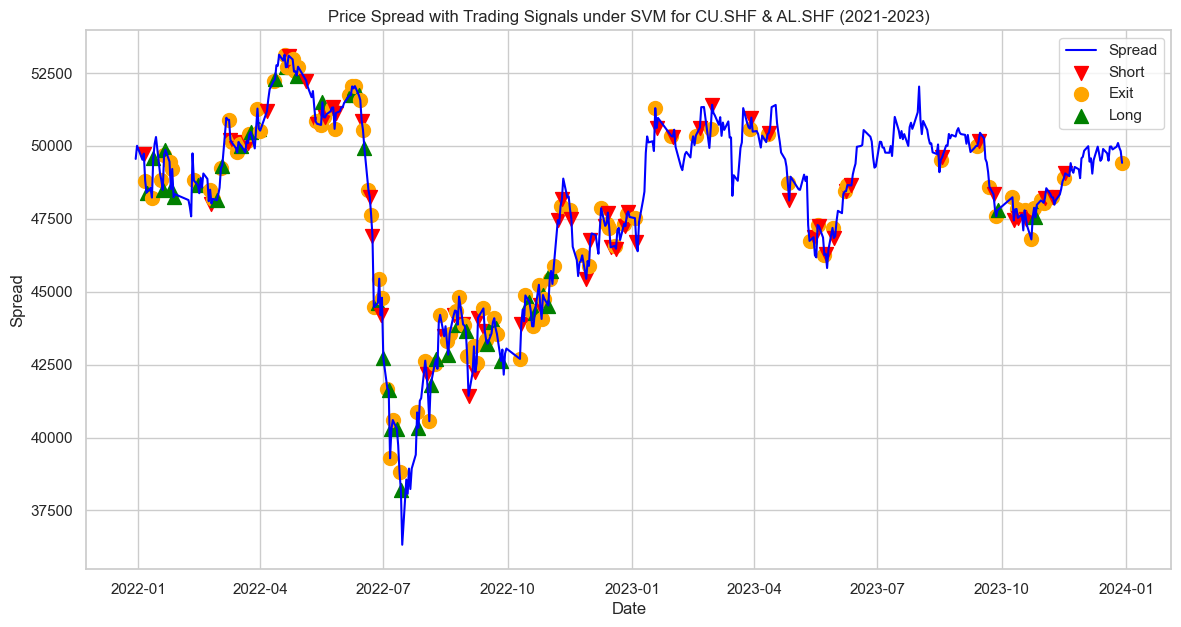

In [168]:
_, signals_svm, date_list = pair_trading(filled_price['CU.SHF'], filled_price['AL.SHF'])
# Full price spread data (replace with your actual data)
full_spread_data = filled_price_20['CU.SHF'] - filled_price_20['AL.SHF']
full_date_list = full_spread_data.index

# Signal data (subset of full data where signals occur)
relevant_rows = filled_price_20.loc[filled_price_20.index.isin(date_list)]
signal_dates = relevant_rows.index
signals = signals_svm
signal_spread = full_spread_data.loc[signal_dates]

# Plot the full spread with signals marked
plot_spread_with_signals_svm(full_date_list, full_spread_data, signal_dates, signal_spread, signals, 'CU.SHF & AL.SHF')



In [253]:
returns_list_svm = {}
strategy_return_svm = []
for pair in pairs_coint:
    prices_asset1 = filled_price[pair[0]]
    prices_asset2 = filled_price[pair[1]]
    strategy_returns, _,  _ = pair_trading(prices_asset1, prices_asset2, lookback=21, kernel='linear', train_size_ratio=0.8)
    strategy_return_svm.append(strategy_returns)

    pair_name = f"{pair[0]}_vs_{pair[1]}"
    returns_list_svm[pair_name] = strategy_returns
    pair_return_svm_df = pd.DataFrame(returns_list_svm)



In [70]:
def calculate_annualized_return_return_based(daily_returns):
    # Filter out any NaNs or extreme values that could distort the results
    daily_returns = daily_returns.replace([np.inf, -np.inf], np.nan).dropna()

    # Check if there are enough data points to calculate the return
    if len(daily_returns) == 0:
        print("No valid returns to calculate.")
        return np.nan

    # Calculate the cumulative return
    cumulative_return = np.prod(1 + daily_returns) - 1

    # Ensure cumulative_return is not an extreme value
    if cumulative_return < -1:
        print("Cumulative return is less than -100%, indicating a total loss. Adjusting to -1.")
        cumulative_return = -1

    # Calculate the number of periods (days)
    n = len(daily_returns)

    # Calculate the annualized return
    annualized_return = (1 + cumulative_return) ** (252 / n) - 1

    return annualized_return


In [255]:
# Calculate weighted portfolio value
portfolio_returns_svm = calculate_weighted_portfolio_value(pair_return_svm_df)

# Calculate annualized return
annualized_return_svm = calculate_annualized_return_return_based(portfolio_returns_svm)


# Drop NaN values before calculating volatility
portfolio_returns_svm = portfolio_returns_svm.dropna()

# Calculate volatility, Sharpe Ratio, and Maximum drawdown
volatility_svm = np.std(portfolio_returns_svm)
sp_svm = calculate_sharpe_ratio(portfolio_returns_svm)

print(f"Portfolio Annualized return: {annualized_return_svm}")
print(f"Volatility: {volatility_svm}")
print(f"Sharpe Ratio: {sp_svm}")



Portfolio Annualized return: 0.05251039151742121
Volatility: 0.01149351140165393
Sharpe Ratio: -1.8559163670278136


In [72]:
class DQN(nn.Module):
    def __init__(self, state_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x, min_value, max_value):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        output = min_value + (max_value - min_value) * torch.sigmoid(x)
        return output


In [73]:

class PairTradingStrategy:
    def __init__(self, price_data, selected_pairs, num):

        self.price_data = price_data  
        self.selected_pairs = selected_pairs  
        self.form_start_date = '20140101'  
        self.form_end_date = '20211231'  
        self.trade_start_date = '20220101'  
        self.trade_end_date = '20231230'  
        self.code_1 = None  
        self.code_2 = None  
        self.entry_threshold = None  
        self.stoploss = None  
        self.takeprofit = None  
        self.initial_capital = 100000000  
        self.transaction_cost_rate = 0.0002  
        self.short_fee_rate = 0.00025  
        self.position_1 = None  
        self.position_2 = None  

        self.dqn = DQN(state_size=3)  
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()


        self.select_trading_pair(num)

    def select_trading_pair(self, num):

        if self.selected_pairs:
            if num < len(self.selected_pairs):
                self.code_1, self.code_2 = self.selected_pairs[num]  
                print(f"Selected trading pair: {self.code_1} and {self.code_2}")
            else:
                print(f"Error: The index {num} is out of range for the selected pairs.")
        else:
            print("No selected pairs provided.")

    def data_process(self):

        data = self.price_data[[self.code_1, self.code_2]]

        form_data = data.loc[self.form_start_date:self.form_end_date].dropna()

        spread_form = form_data[self.code_1] - form_data[self.code_2]

        min_spread_form = spread_form.min()
        max_spread_form = spread_form.max()
        spread_form_normalized = 2 * ((spread_form - min_spread_form) / (max_spread_form - min_spread_form)) - 1

        trade_data = data.loc[self.trade_start_date:self.trade_end_date].dropna()

        trade_data['spread_trade'] = trade_data[self.code_1] - trade_data[self.code_2]

        trade_data['spread_normalized_trade'] = 2 * (
            (trade_data['spread_trade'] - min_spread_form) / (max_spread_form - min_spread_form)) - 1

        min_value = trade_data['spread_normalized_trade'].min()
        max_value = trade_data['spread_normalized_trade'].max()

        stoploss_adjustment = (max_value - min_value) * 0.15  
        takeprofit_adjustment = (max_value - min_value) * 0.15  

        state = torch.tensor([trade_data['spread_normalized_trade'].iloc[-1], min_value, max_value], dtype=torch.float32)
        self.entry_threshold = self.dqn(state, min_value, max_value).item()  
        self.stoploss = self.entry_threshold + stoploss_adjustment  
        self.takeprofit = self.entry_threshold - takeprofit_adjustment  

        print(f"spread_normalized_trade min value: {min_value:.3f}, "
              f"max value: {max_value:.3f}, "
              f"Stop loss point with RL: {self.stoploss:.3f}, "
              f"Stop earning porint with RL: {self.takeprofit:.3f}, "
              f"Entry point with RL: {self.entry_threshold:.3f}")

        return trade_data  

    def pair_strategy(self):
        trades = []
        position = 0 # 0: no position, 1: long, -1: short
        current_position = {self.code_1: 0, self.code_2: 0} 
        capital = self.initial_capital 
        df = self.data_process()
        df.index = pd.to_datetime(df.index)

        for i in range(1, len(df)):
            # long：spread_normalized_trade > entry_threshold and spread_normalized_trade < stoploss，and no position
            if df['spread_normalized_trade'].iloc[i] > self.entry_threshold and df['spread_normalized_trade'].iloc[
                i] < self.stoploss and position == 0:

                quantity_1 = capital / df[self.code_1].iloc[i] // 100 * 100
                quantity_2 = capital / df[self.code_2].iloc[i] // 100 * 100

                cost_1 = df[self.code_1].iloc[i] * self.transaction_cost_rate * quantity_1
                cost_2 = df[self.code_2].iloc[i] * self.transaction_cost_rate * quantity_2

                self.position_1 = 'Short'
                self.position_2 = 'Long'

                trades.append({
                    'trade_date': df.index[i],
                    'spread_normalized_trade': df['spread_normalized_trade'].iloc[i],
                    'action': 'Short/Long',
                    'stock_1': self.code_1,
                    'price_1': df[self.code_1].iloc[i],
                    'quantity_1': quantity_1,
                    'cost_1': cost_1,
                    'stock_2': self.code_2,
                    'price_2': df[self.code_2].iloc[i],
                    'quantity_2': quantity_2,
                    'cost_2': cost_2,
                    'position_1': self.position_1,
                    'position_2': self.position_2,
                    'interest_start_date': df.index[i],
                    'holding_days': 0,
                    'interest': 0,
                    'stock1_profit': 0,
                    'stock2_profit': 0,
                    'total_profit': 0,
                    'signal': 1
                })
                position = 1
                current_position[self.code_1] += quantity_1
                current_position[self.code_2] += quantity_2

            # short：spread_normalized_trade < -entry_threshold and > -stoploss，and no position
            elif df['spread_normalized_trade'].iloc[i] < -self.entry_threshold and df['spread_normalized_trade'].iloc[
                i] > -self.stoploss and position == 0:
                quantity_1 = capital / df[self.code_1].iloc[i] // 100 * 100
                quantity_2 = capital / df[self.code_2].iloc[i] // 100 * 100

                cost_1 = df[self.code_1].iloc[i] * self.transaction_cost_rate * quantity_1
                cost_2 = df[self.code_2].iloc[i] * self.transaction_cost_rate * quantity_2

                self.position_1 = 'Long'
                self.position_2 = 'Short'

                trades.append({
                    'trade_date': df.index[i],
                    'spread_normalized_trade': df['spread_normalized_trade'].iloc[i],
                    'action': 'Long/Short',
                    'stock_1': self.code_1,
                    'price_1': df[self.code_1].iloc[i],
                    'quantity_1': quantity_1,
                    'cost_1': cost_1,
                    'stock_2': self.code_2,
                    'price_2': df[self.code_2].iloc[i],
                    'quantity_2': quantity_2,
                    'cost_2': cost_2,
                    'position_1': self.position_1,
                    'position_2': self.position_2,
                    'interest_start_date': df.index[i],
                    'holding_days': 0,
                    'interest': 0,
                    'stock1_profit': 0,
                    'stock2_profit': 0,
                    'total_profit': 0,
                    'signal': -1
                })
                position = -1
                current_position[self.code_1] += quantity_1
                current_position[self.code_2] += quantity_2

            # exit long：spread_normalized_trade > stoploss or < takeprofit，and have long position
            elif (df['spread_normalized_trade'].iloc[i] > self.stoploss and position == 1) or (
                    df['spread_normalized_trade'].iloc[i] < self.takeprofit and position == 1):
                cost_1 = df[self.code_1].iloc[i] * self.transaction_cost_rate * current_position[self.code_1]
                cost_2 = df[self.code_2].iloc[i] * self.transaction_cost_rate * current_position[self.code_2]

                buy_date = trades[-1]['interest_start_date']
                interest_days = (df.index[i] - buy_date).days
                interest = capital * self.short_fee_rate * interest_days

                stock1_profit = (df[self.code_1].iloc[i] - trades[-1]['price_1']) * current_position[
                    self.code_1]*-1
                stock2_profit = (trades[-1]['price_2'] - df[self.code_2].iloc[i]) * current_position[
                    self.code_2]*-1
                total_profit = stock1_profit + stock2_profit - cost_1 - cost_2 - interest

                self.position_1 = 'Exit'
                self.position_2 = 'Exit'

                trades.append({
                    'trade_date': df.index[i],
                    'spread_normalized_trade': df['spread_normalized_trade'].iloc[i],
                    'action': 'Exit',
                    'stock_1': self.code_1,
                    'price_1': df[self.code_1].iloc[i],
                    'quantity_1': current_position[self.code_1],
                    'cost_1': cost_1,
                    'stock_2': self.code_2,
                    'price_2': df[self.code_2].iloc[i],
                    'quantity_2': current_position[self.code_2],
                    'cost_2': cost_2,
                    'position_1': self.position_1,
                    'position_2': self.position_2,
                    'interest_start_date': None,
                    'holding_days': interest_days,
                    'interest': interest,
                    'stock1_profit': stock1_profit,
                    'stock2_profit': stock2_profit,
                    'total_profit': total_profit,
                    'signal': 0
                })
                position = 0
                current_position[self.code_1] = 0
                current_position[self.code_2] = 0

            # exit short：spread_normalized_trade < -stoploss or > -takeprofit，have short position
            elif (df['spread_normalized_trade'].iloc[i] < -self.stoploss and position == -1) or (
                    df['spread_normalized_trade'].iloc[i] > -self.takeprofit and position == -1):
                cost_1 = df[self.code_1].iloc[i] * self.transaction_cost_rate * current_position[self.code_1]
                cost_2 = df[self.code_2].iloc[i] * self.transaction_cost_rate * current_position[self.code_2]

                buy_date = trades[-1]['interest_start_date']
                interest_days = (df.index[i] - buy_date).days
                interest = capital * self.short_fee_rate * interest_days

                stock1_profit = (df[self.code_1].iloc[i] - trades[-1]['price_1']) * current_position[
                    self.code_1]
                stock2_profit = (trades[-1]['price_2'] - df[self.code_2].iloc[i]) * current_position[
                    self.code_2]
                total_profit = stock1_profit + stock2_profit - cost_1 - cost_2 - interest

                self.position_1 = 'Exit'
                self.position_2 = 'Exit'

                trades.append({
                    'trade_date': df.index[i],
                    'spread_normalized_trade': df['spread_normalized_trade'].iloc[i],
                    'action': 'Exit',
                    'stock_1': self.code_1,
                    'price_1': df[self.code_1].iloc[i],
                    'quantity_1': current_position[self.code_1],
                    'cost_1': cost_1,
                    'stock_2': self.code_2,
                    'price_2': df[self.code_2].iloc[i],
                    'quantity_2': current_position[self.code_2],
                    'cost_2': cost_2,
                    'position_1': self.position_1,
                    'position_2': self.position_2,
                    'interest_start_date': None,
                    'holding_days': interest_days,
                    'interest': interest,
                    'stock1_profit': stock1_profit,
                    'stock2_profit': stock2_profit,
                    'total_profit': total_profit,
                    'signal': 0
                })
                position = 0
                current_position[self.code_1] = 0
                current_position[self.code_2] = 0

        trades_df = pd.DataFrame(trades)

        trades_df['cumulative_profit'] = trades_df['total_profit'].cumsum()

        trades_df.to_excel('DQN_'+self.code_1+'_'+self.code_2+'_trades_record.xlsx', index=False)

        return trades_df

    def strategy_evaluate(self):

        df = self.data_process()
        df.index = pd.to_datetime(df.index)
        df_trades = self.pair_strategy()
        if df_trades.empty:
            print("No trades were made during the trading period.")
            return None

        df_trades['date'] = df_trades['trade_date'].dt.date
        df_trades['daily_return'] = df_trades['total_profit'] / self.initial_capital
        df_trades['cum_return'] = (1 + df_trades['daily_return']).cumprod() - 1
        df_trades['total_profit_cumsum'] = df_trades['total_profit'].cumsum()
        df_trades['capital'] = self.initial_capital + df_trades['total_profit_cumsum']

        df_trades['peak'] = df_trades['capital'].cummax()
        df_trades['drawdown'] = (df_trades['capital'] - df_trades['peak']) / df_trades['peak']
        max_drawdown = df_trades['drawdown'].min()

        daily_return_mean = df_trades['daily_return'].mean()
        daily_return_std = df_trades['daily_return'].std()
        sharpe_ratio = (daily_return_mean / daily_return_std) * (252 ** 0.5) if daily_return_std != 0 else 0

        num_trades = len(df_trades)
        winning_trades = df_trades[df_trades['total_profit'] > 0]
        win_rate = len(winning_trades) / num_trades if num_trades > 0 else 0

        performance_summary = {
            'Total Return': df_trades['total_profit_cumsum'].iloc[-1],
            'Max Drawdown': max_drawdown,
            'Sharpe Ratio': sharpe_ratio,
            'Number of Trades': num_trades,
            'Win Rate': win_rate,
        }

        print("Performance Summary:")
        for key, value in performance_summary.items():
            print(f"{key}: {value}")

        return df_trades, performance_summary

strategy = PairTradingStrategy(filled_price, pairs_coint, num=0)
trades_df = strategy.pair_strategy()
trades_df


Selected trading pair: CU.SHF and AL.SHF
spread_normalized_trade min value: -0.219, max value: 0.757, Stop loss point with RL: 0.413, Stop earning porint with RL: 0.121, Entry point with RL: 0.267


,trade_date,spread_normalized_trade,action,stock_1,price_1,quantity_1,cost_1,stock_2,price_2,quantity_2,...,position_1,position_2,interest_start_date,holding_days,interest,stock1_profit,stock2_profit,total_profit,signal,cumulative_profit
0,2022-06-23,0.395497,Short/Long,CU.SHF,66380,1500.0,19914.0,AL.SHF,19485,5100.0,...,Short,Long,2022-06-23,0,0.0,0.0,0.0,0.0,1,0.0
1,2022-07-04,0.092520,Exit,CU.SHF,60660,1500.0,18198.0,AL.SHF,18980,5100.0,...,Exit,Exit,NaT,11,275000.0,8580000.0,-2575500.0,5691942.4,0,5691942.4
2,2022-08-26,0.275527,Short/Long,CU.SHF,63690,1500.0,19107.0,AL.SHF,18860,5300.0,...,Short,Long,2022-08-26,0,0.0,0.0,0.0,0.0,1,5691942.4
3,2022-09-02,0.077996,Exit,CU.SHF,59540,1500.0,17862.0,AL.SHF,18110,5300.0,...,Exit,Exit,NaT,7,175000.0,6225000.0,-3975000.0,2037941.4,0,7729883.8
4,2022-10-14,0.277850,Short/Long,CU.SHF,63700,1500.0,19110.0,AL.SHF,18830,5300.0,...,Short,Long,2022-10-14,0,0.0,0.0,0.0,0.0,1,7729883.8
5,2022-11-07,0.428032,Exit,CU.SHF,65730,1500.0,19719.0,AL.SHF,18275,5300.0,...,Exit,Exit,NaT,24,600000.0,-3045000.0,-2941500.0,-6625590.5,0,1104293.3
6,2022-11-18,0.374873,Short/Long,CU.SHF,65740,1500.0,19722.0,AL.SHF,19200,5200.0,...,Short,Long,2022-11-18,0,0.0,0.0,0.0,0.0,1,1104293.3
7,2022-12-09,0.451561,Exit,CU.SHF,67120,1500.0,20136.0,AL.SHF,19260,5200.0,...,Exit,Exit,NaT,21,525000.0,-2070000.0,312000.0,-2323166.4,0,-1218873.1
8,2022-12-15,0.412055,Short/Long,CU.SHF,65980,1500.0,19794.0,AL.SHF,18800,5300.0,...,Short,Long,2022-12-15,0,0.0,0.0,0.0,0.0,1,-1218873.1
9,2022-12-26,0.420479,Exit,CU.SHF,66040,1500.0,19812.0,AL.SHF,18715,5300.0,...,Exit,Exit,NaT,11,275000.0,-90000.0,-450500.0,-855149.9,0,-2074023.0


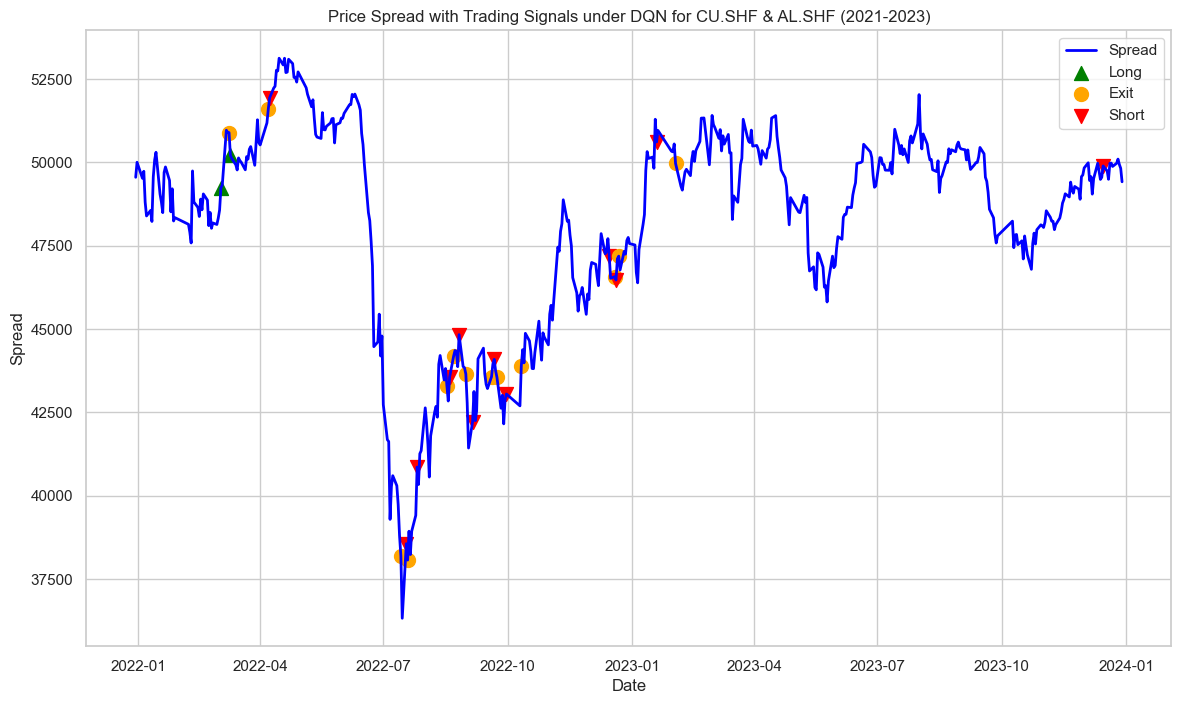

In [166]:
def plot_trading_actions_rl(trades_df, full_spread_data, pair_name):
    plt.figure(figsize=(14, 8))
    
    # Plot the spread data
    plt.plot(full_spread_data.index, full_spread_data.values, label='Spread', color='blue', linewidth=2)
    
    # Plot the trading actions
    for i, trade in trades_df.iterrows():
        if trade['action'] == 'Short/Long':
            plt.scatter(trade['trade_date'], full_spread_data.loc[trade['trade_date']], color='red',
                        label='Short' if 'Short' not in plt.gca().get_legend_handles_labels()[1] else "",
                        marker='v', s=100)
        elif trade['action'] == 'Exit':
            plt.scatter(trade['trade_date'], full_spread_data.loc[trade['trade_date']], color='orange',
                        label='Exit' if 'Exit' not in plt.gca().get_legend_handles_labels()[1] else "",
                        marker='o', s=100)
        elif trade['action'] == 'Long/Short':
            plt.scatter(trade['trade_date'], full_spread_data.loc[trade['trade_date']], color='green',
                        label='Long' if 'Long' not in plt.gca().get_legend_handles_labels()[1] else "",
                        marker='^', s=100)
    
    plt.title(f'Price Spread with Trading Signals under DQN for {pair_name} (2021-2023)')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
full_spread_data = filled_price_20['CU.SHF'] - filled_price_20['AL.SHF']
plot_trading_actions_rl(trades_df, full_spread_data, 'CU.SHF & AL.SHF')


In [142]:
import pandas as pd

if __name__ == "__main__":

    returns_rl = {}

    for n in range(0, len(pairs_coint)):
        port_value_list = []
        port_value = 0
        dates = filled_price_20.index
        pair = pairs_coint[n]
        # Initialize the PairTradingStrategy with the price data and selected pair
        strategy = PairTradingStrategy(filled_price, pairs_coint, n)
        # Execute the trading strategy
        trades_df = strategy.pair_strategy()
        count_1 = 0
        count_2 = 0


        for j in range(0, len(dates)):
            if dates[j] not in trades_df['trade_date'].values:
                if j == 0:
                    port_value_list.append(0)
                else:
                    port_value_list.append(port_value_list[-1])
   
            else:
                for i in range(0, len(trades_df)):
                    signal_date = trades_df['trade_date'][i]
                    if dates[j] == signal_date: 
                        price_1 = filled_price[pair[0]][signal_date]
                        price_2 = filled_price[pair[1]][signal_date]
                        ratio = price_1/price_2
                        if trades_df['action'][i] == 'Long/Short':
                            port_value += price_1 - ratio * price_2 
                            port_value_list.append(port_value)
                            count_1 -= 1
                            count_2 += ratio
                            
                        elif trades_df['action'][i] == 'Short/Long':
                            port_value += ratio * price_2 - price_1 - ratio 
                            port_value_list.append(port_value)
                            count_1 += 1
                            count_2 -= ratio
                        elif trades_df['action'][i] == 'Exit':
                            port_value += count_1 * price_1 + count_2 * price_2
                            port_value_list.append(port_value)
                            count_1 = 0
                            count_2 = 0


        pair_name = f"{pair[0]}_vs_{pair[1]}"
        returns_rl[pair_name] = port_value_list
        return_rl_df = pd.DataFrame(returns_rl)

return_rl_df


Selected trading pair: CU.SHF and AL.SHF
spread_normalized_trade min value: -0.219, max value: 0.757, Stop loss point with RL: 0.394, Stop earning porint with RL: 0.101, Entry point with RL: 0.247
Selected trading pair: AL.SHF and SN.SHF
spread_normalized_trade min value: -1.907, max value: 0.342, Stop loss point with RL: -0.358, Stop earning porint with RL: -1.033, Entry point with RL: -0.695
Selected trading pair: AL.SHF and M.DCE
spread_normalized_trade min value: -0.168, max value: 0.782, Stop loss point with RL: 0.418, Stop earning porint with RL: 0.133, Entry point with RL: 0.275
Selected trading pair: AL.SHF and P.DCE
spread_normalized_trade min value: -0.443, max value: 0.593, Stop loss point with RL: 0.263, Stop earning porint with RL: -0.048, Entry point with RL: 0.108
Selected trading pair: NI.SHF and M.DCE
spread_normalized_trade min value: 0.250, max value: 3.466, Stop loss point with RL: 2.469, Stop earning porint with RL: 1.504, Entry point with RL: 1.986
Selected tradin

,CU.SHF_vs_AL.SHF,AL.SHF_vs_SN.SHF,AL.SHF_vs_M.DCE,AL.SHF_vs_P.DCE,NI.SHF_vs_M.DCE,SN.SHF_vs_P.DCE,RU.SHF_vs_FU.SHF,RU.SHF_vs_BU.SHF,RU.SHF_vs_A.DCE,RU.SHF_vs_B.DCE,...,B.DCE_vs_P.DCE,M.DCE_vs_Y.DCE,M.DCE_vs_P.DCE,M.DCE_vs_C.DCE,M.DCE_vs_CS.DCE,Y.DCE_vs_P.DCE,C.DCE_vs_CS.DCE,JD.DCE_vs_L.DCE,JD.DCE_vs_V.DCE,JD.DCE_vs_PP.DCE
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,-6.188886,-2.311706,0.000000,-33.520871,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,-0.373525,0.000000,0.000000,-1.818989e-12,-0.900664,0.000000,0.000000,0.000000
4,0.000000,0.000000,781.544185,506.118421,0.000000,-33.520871,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,-0.373525,0.000000,0.000000,-1.818989e-12,-0.900664,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2305.144204,2941.385547,439.869902,-13821.412853,24816.913745,-4816.949663,-6918.829176,-1696.754558,-1315.49321,-1151.845172,...,2623.10714,1075.963691,42.243796,209.100452,-906.288854,2.598564e+03,-451.188948,730.954687,408.879951,52.720421
482,2305.144204,2941.385547,439.869902,-13821.412853,24816.913745,-4816.949663,-6918.829176,-1696.754558,-1315.49321,-1151.845172,...,2623.10714,1075.963691,42.243796,209.100452,-906.288854,2.598564e+03,-451.188948,730.954687,408.879951,52.720421
483,2305.144204,2941.385547,439.869902,-13821.412853,24816.913745,-4816.949663,-6918.829176,-1696.754558,-1315.49321,-1151.845172,...,2623.10714,1075.963691,42.243796,209.100452,-906.288854,2.598564e+03,-451.188948,224.747533,408.879951,52.720421
484,2305.144204,2941.385547,439.869902,-13821.412853,24816.913745,-4816.949663,-6918.829176,-1696.754558,-1315.49321,-1151.845172,...,2623.10714,1075.963691,42.243796,209.100452,-906.288854,2.598564e+03,-451.188948,224.747533,408.879951,52.720421


In [256]:
# Calculate weighted portfolio value
portfolio_values_rl = calculate_weighted_portfolio_value(return_rl_df)

# Calculate annualized return
annualized_return_rl = annualized_return(portfolio_values_rl, 2)

# Calculate percentage returns, handling NaN values
portfolio_returns_rl= calculate_percentage_returns(portfolio_values_rl)

# Drop NaN values before calculating volatility
portfolio_returns_rl = portfolio_returns_rl.dropna()

# Calculate volatility
volatility_rl = np.std(portfolio_returns_rl)

sp_rl = calculate_sharpe_ratio(portfolio_returns_rl)

print(f"Portfolio Annualized return: {annualized_return_rl}")
print(f"Volatility: {volatility_rl}")
print(f"Sharpe Ratio: {sp_rl}")




Portfolio Annualized return: -6.606298178277264
Volatility: 1.8695775480880072
Sharpe Ratio: 0.055225943633104645


In [77]:
# Data for analyzing macro economice indicators and related future commidity prices in foreign markets
foreign_prices = pd.read_excel('/price data.xlsx')
foreign_prices = foreign_prices[['Date', '000979.CSI', 'GC.CMX', 'SI.CMX', 'HG.CMX', 'PL.NYM', 'PA.NYM']]
foreign_prices['Date'] = pd.to_datetime(foreign_prices['Date'], errors='coerce')
foreign_prices.set_index('Date', inplace=True)

foreign_prices



,000979.CSI,GC.CMX,SI.CMX,HG.CMX,PL.NYM,PA.NYM
Date,,,,,,
2014-01-02,2823.2990,1222.4,20.000,3.3860,1401.9,729.70
2014-01-03,2795.2800,1237.4,20.135,3.3525,1413.1,727.50
2014-01-06,2702.5350,1236.9,20.160,3.3580,1417.9,738.75
2014-01-07,2701.6170,1230.9,19.835,3.3470,1416.8,742.20
2014-01-08,2678.5240,1225.0,19.510,3.3505,1417.6,736.55
...,...,...,...,...,...,...
2023-12-25,4622.1331,2064.5,24.470,3.9015,979.9,1217.50
2023-12-26,4604.9961,2079.2,24.500,3.9025,985.1,1190.50
2023-12-27,4629.0036,2089.4,24.545,3.9550,1015.8,1164.00


In [78]:
# Remove columns with more than 1000 NaN values
columns_to_remove_foreign = foreign_prices.columns[foreign_prices.isna().sum() > 1000]
cleaned_foreign = foreign_prices.drop(columns=columns_to_remove_foreign)

# Fill remaining NaN values with the mean of the column
filled_foreign = cleaned_foreign.fillna(cleaned_foreign.mean())
print(filled_foreign.head())

            000979.CSI  GC.CMX  SI.CMX  HG.CMX  PL.NYM  PA.NYM
Date                                                          
2014-01-02    2823.299  1222.4  20.000  3.3860  1401.9  729.70
2014-01-03    2795.280  1237.4  20.135  3.3525  1413.1  727.50
2014-01-06    2702.535  1236.9  20.160  3.3580  1417.9  738.75
2014-01-07    2701.617  1230.9  19.835  3.3470  1416.8  742.20
2014-01-08    2678.524  1225.0  19.510  3.3505  1417.6  736.55


In [79]:
macro['Date'] = pd.to_datetime(macro['Date'], errors='coerce')
macro.set_index('Date', inplace=True)

macro

,GDP,PPI,CPI,CCPI,LPR-5,LPR-1
Date,,,,,,
2014-01-01,1378.141111,-1.64,2.4861,141.08,NaN,5.73
2014-01-02,1378.141111,-1.64,2.4861,141.08,NaN,5.73
2014-01-03,1378.141111,-1.64,2.4861,141.08,NaN,5.73
2014-01-04,1378.141111,-1.64,2.4861,141.08,NaN,5.73
2014-01-05,1378.141111,-1.64,2.4861,141.08,NaN,5.73
...,...,...,...,...,...,...
2023-12-27,3608.521739,-2.70,-0.3000,182.05,4.2,3.45
2023-12-28,3608.521739,-2.70,-0.3000,182.05,4.2,3.45
2023-12-29,3608.521739,-2.70,-0.3000,182.05,4.2,3.45


In [80]:
# Remove columns with more than 1000 NaN values
columns_to_remove_macro = macro.columns[macro.isna().sum() > 1000]
cleaned_macro = macro.drop(columns=columns_to_remove_macro)

# Fill remaining NaN values with the mean of the column
filled_macro = cleaned_macro.fillna(cleaned_macro.mean())
# Align the index of filled_macro with filled_price
filled_macro_aligned = filled_macro.reindex(filled_price.index)

# Print the aligned filled_macro DataFrame
print(filled_macro_aligned)



                    GDP   PPI     CPI    CCPI  LPR-1
Date                                                
2014-01-02  1378.141111 -1.64  2.4861  141.08   5.73
2014-01-03  1378.141111 -1.64  2.4861  141.08   5.73
2014-01-06  1378.141111 -1.64  2.4861  141.08   5.73
2014-01-07  1378.141111 -1.64  2.4861  141.08   5.73
2014-01-08  1378.141111 -1.64  2.4861  141.08   5.73
...                 ...   ...     ...     ...    ...
2023-12-25  3608.521739 -2.70 -0.3000  182.05   3.45
2023-12-26  3608.521739 -2.70 -0.3000  182.05   3.45
2023-12-27  3608.521739 -2.70 -0.3000  182.05   3.45
2023-12-28  3608.521739 -2.70 -0.3000  182.05   3.45
2023-12-29  3608.521739 -2.70 -0.3000  182.05   3.45

[2434 rows x 5 columns]


In [202]:
filled_macro_aligned_1 = pd.merge(filled_macro_aligned, filled_foreign['000979.CSI'], on='Date')
filled_macro_aligned_1.describe().round(2)

,GDP,PPI,CPI,CCPI,LPR-1,000979.CSI
count,2434.00,2434.00,2434.00,2434.00,2434.00,2434.00
mean,2396.66,0.85,1.76,143.54,4.28,4340.55
std,592.58,4.68,1.05,32.27,0.62,921.01
min,1378.14,-5.94,-0.50,81.48,3.45,2493.08
25%,1977.89,-2.60,1.30,122.02,3.85,3662.67
50%,2388.78,-0.70,1.80,138.98,4.30,4286.37
75%,2950.35,4.60,2.30,175.94,4.31,4988.28
max,3608.52,13.50,5.40,210.32,5.77,7297.08


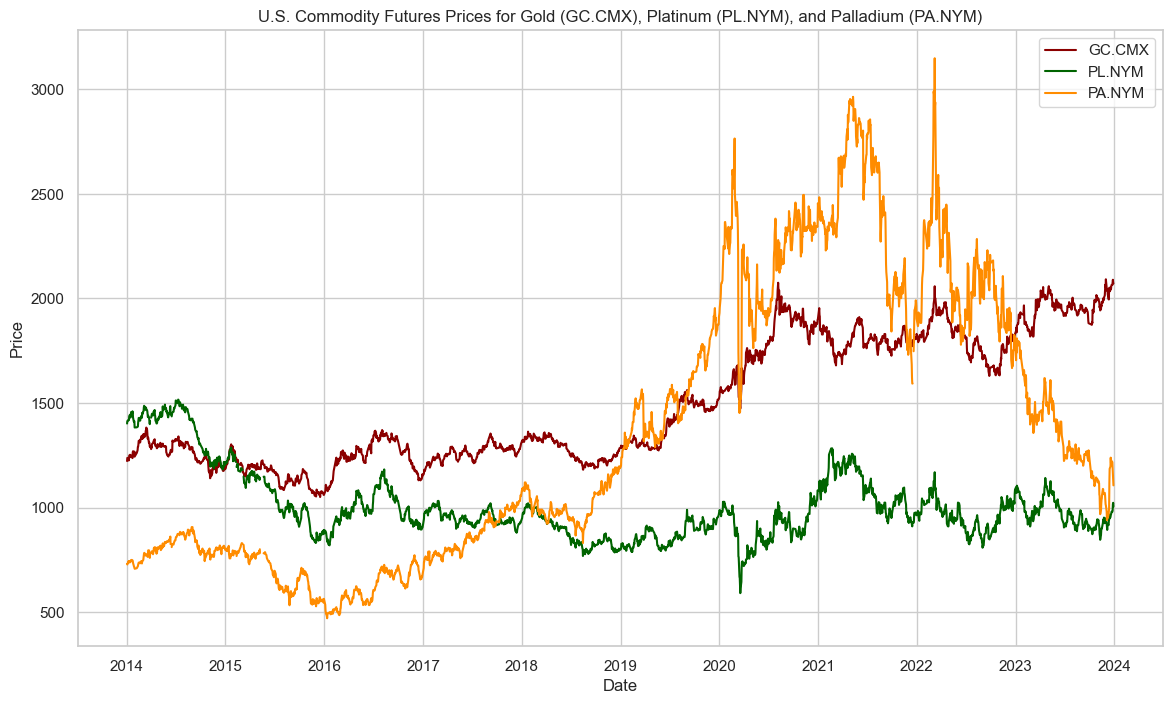

In [207]:
plt.figure(figsize=(14, 8))

plt.plot(foreign_prices.index, foreign_prices['GC.CMX'], label='GC.CMX', color='darkred')

plt.plot(foreign_prices.index, foreign_prices['PL.NYM'], label='PL.NYM', color='darkgreen')
plt.plot(foreign_prices.index, foreign_prices['PA.NYM'], label='PA.NYM', color='darkorange')


plt.title('U.S. Commodity Futures Prices for Gold (GC.CMX), Platinum (PL.NYM), and Palladium (PA.NYM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


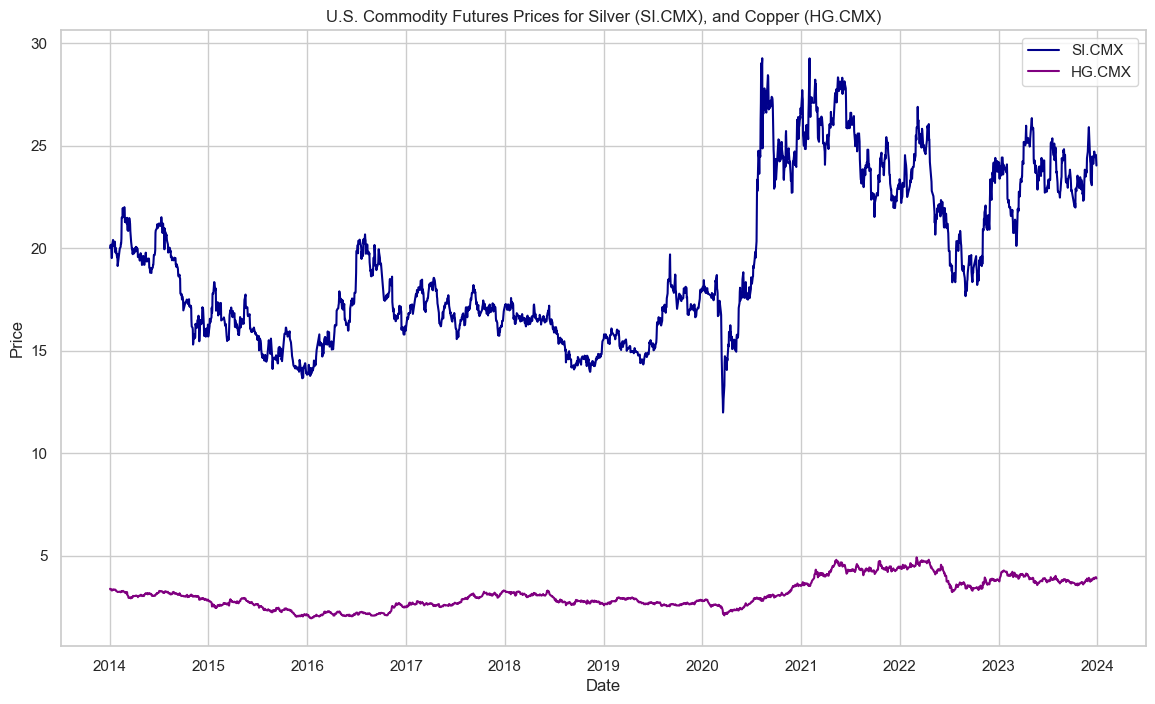

In [208]:
plt.figure(figsize=(14, 8))

plt.plot(foreign_prices.index, foreign_prices['SI.CMX'], label='SI.CMX', color='darkblue')
plt.plot(foreign_prices.index, foreign_prices['HG.CMX'], label='HG.CMX', color='purple')

plt.title('U.S. Commodity Futures Prices for Silver (SI.CMX), and Copper (HG.CMX)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

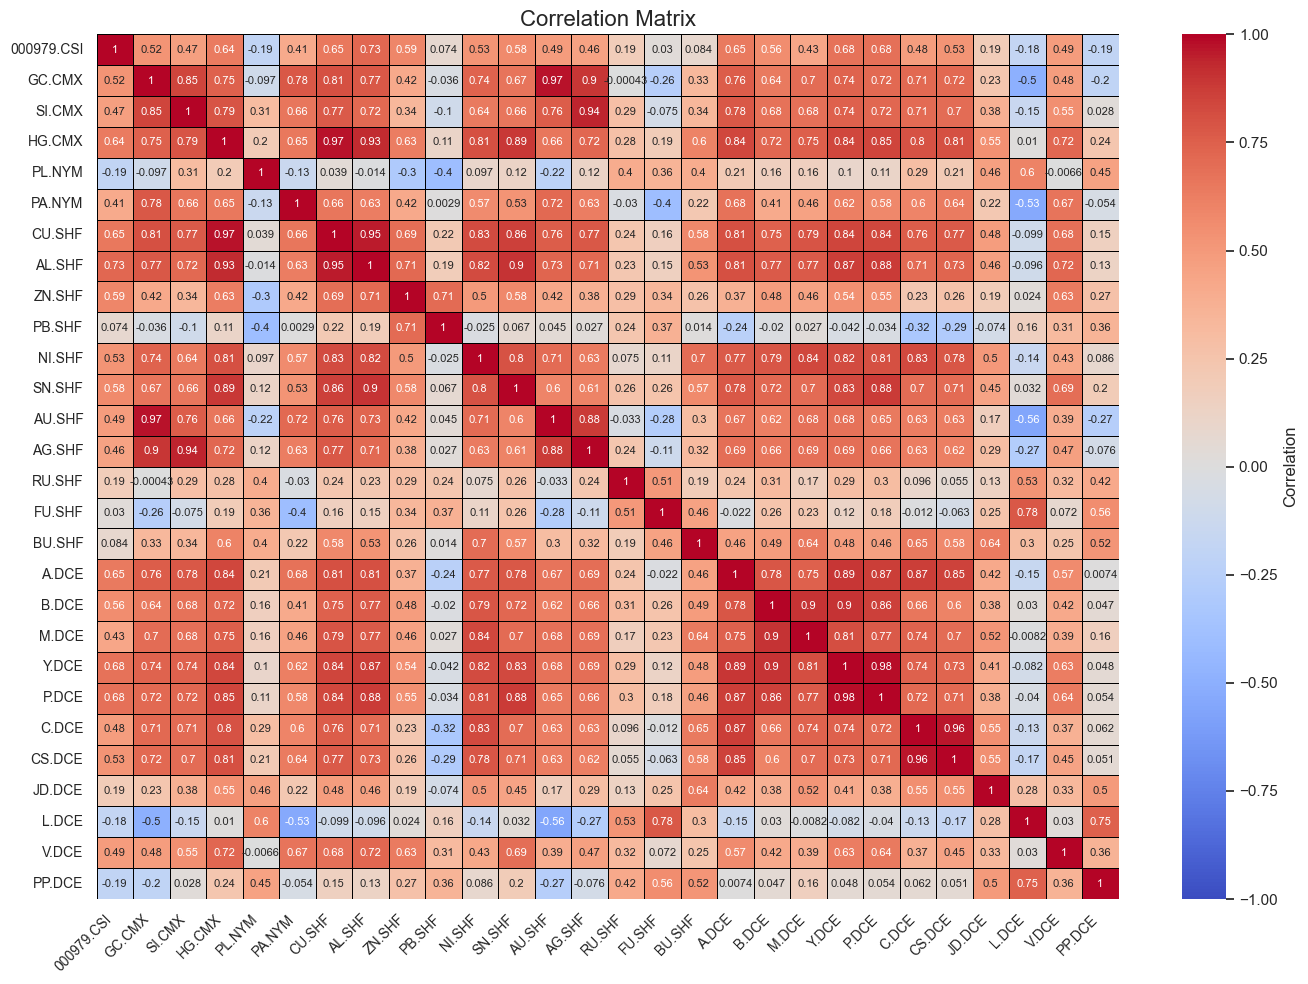

In [217]:
merged_commodity = pd.merge(foreign_prices, filled_price, on='Date', how='left')
merged_commodity_1 = pd.merge(foreign_prices[['GC.CMX', 'SI.CMX', 'HG.CMX', 'PL.NYM', 'PA.NYM']], filled_price, on='Date', how='left')
correlation_matrix_foreign = merged_commodity.corr()

# Set the figure size for better visibility
plt.figure(figsize=(14, 10))

# Create a heatmap with improved settings
sns.heatmap(correlation_matrix_foreign, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, vmax=1, 
            annot_kws={"size": 8},  # Adjust font size of the annotations
            cbar_kws={'label': 'Correlation'},  # Add label to the color bar
            linewidths=0.5,  # Add lines between squares
            linecolor='black'  # Color of the lines between squares
           )

# Improve the title and layout
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Adjust the layout to fit all elements properly

# Show the plot
plt.show()



In [218]:
foreign_commodities = ['GC.CMX', 'SI.CMX', 'HG.CMX', 'PL.NYM', 'PA.NYM', '000979.CSI']  # Example list of foreign commodity columns
commodities = filled_price.columns  # Define your commodities list here, excluding 000979.CSI

# Set the correlation threshold
threshold = 0.5

# List to store highly correlated foreign pairs without correlation values
highly_correlated_foreign_pairs = []

# Loop through foreign commodities and correlated pairs
for foreign_commodity in foreign_commodities:
    for commodity in commodities:
        if commodity != foreign_commodity and commodity != '000979.CSI' and abs(correlation_matrix_foreign.loc[foreign_commodity, commodity]) > threshold:
            pair = (foreign_commodity, commodity)  # Only include the foreign commodity and correlated commodity
            highly_correlated_foreign_pairs.append(pair)

# Convert to DataFrame for better visualization
highly_correlated_foreign_df = pd.DataFrame(highly_correlated_foreign_pairs, columns=['Foreign_Commodity', 'Commodity'])
print(highly_correlated_foreign_df)


   Foreign_Commodity Commodity
0             GC.CMX    CU.SHF
1             GC.CMX    AL.SHF
2             GC.CMX    NI.SHF
3             GC.CMX    SN.SHF
4             GC.CMX    AU.SHF
..               ...       ...
63        000979.CSI     A.DCE
64        000979.CSI     B.DCE
65        000979.CSI     Y.DCE
66        000979.CSI     P.DCE
67        000979.CSI    CS.DCE

[68 rows x 2 columns]


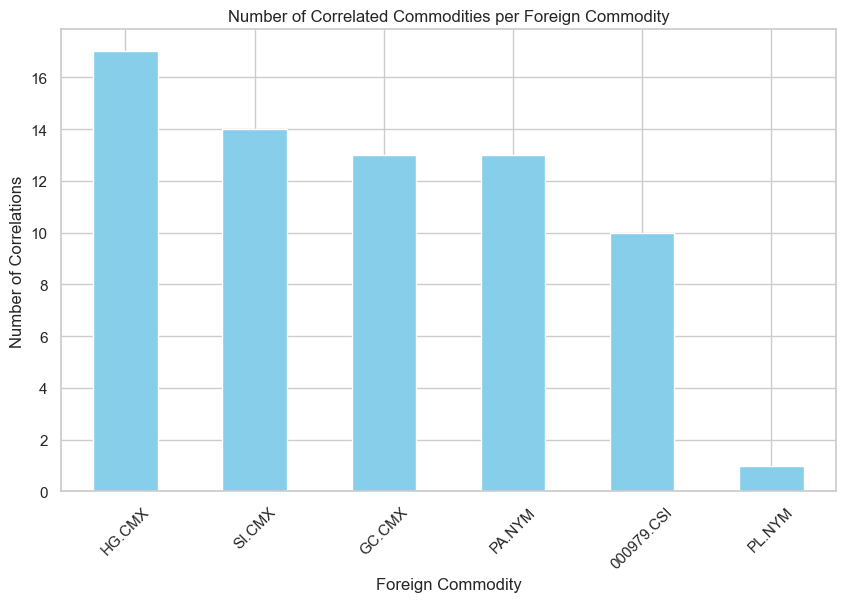

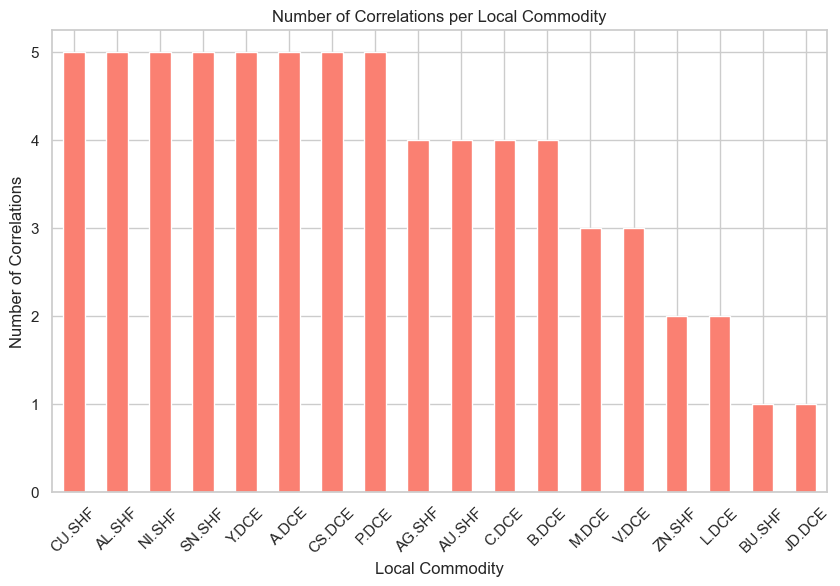

In [257]:

# Bar plot of the number of correlations for each foreign commodity
foreign_commodity_counts = highly_correlated_foreign_df['Foreign_Commodity'].value_counts()

plt.figure(figsize=(10, 6))
foreign_commodity_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Correlated Commodities per Foreign Commodity')
plt.xlabel('Foreign Commodity')
plt.ylabel('Number of Correlations')
plt.xticks(rotation=45)
plt.show()

# Bar plot of the number of correlations for each local commodity
local_commodity_counts = highly_correlated_foreign_df['Commodity'].value_counts()

plt.figure(figsize=(10, 6))
local_commodity_counts.plot(kind='bar', color='salmon')
plt.title('Number of Correlations per Local Commodity')
plt.xlabel('Local Commodity')
plt.ylabel('Number of Correlations')
plt.xticks(rotation=45)
plt.show()





In [219]:
# Perform statistical tests for each foreign correlated pair
foreign_results = []

for pair in highly_correlated_foreign_pairs:
    foreign_commodity, commodity = pair
    
    # Pearson correlation
    pearson_corr, pearson_p_value = pearsonr(filled_foreign[foreign_commodity], filled_price[commodity])

    foreign_results.append({
        'Foreign_Commodity': foreign_commodity,
        'Commodity': commodity,
        'Pearson_Correlation': pearson_corr,
        'Pearson_P_value': pearson_p_value,

    })

# Convert results to DataFrame
foreign_results_df = pd.DataFrame(foreign_results)
print(foreign_results_df)
foreign_results_df.to_excel('foreign_results.xlsx', index=False)  # Excel


   Foreign_Commodity Commodity  Pearson_Correlation  Pearson_P_value
0             GC.CMX    CU.SHF             0.805712     0.000000e+00
1             GC.CMX    AL.SHF             0.773725     0.000000e+00
2             GC.CMX    NI.SHF             0.740947     0.000000e+00
3             GC.CMX    SN.SHF             0.671714    3.228225e-319
4             GC.CMX    AU.SHF             0.974200     0.000000e+00
..               ...       ...                  ...              ...
63        000979.CSI     A.DCE             0.646713    2.131713e-288
64        000979.CSI     B.DCE             0.557089    1.725701e-198
65        000979.CSI     Y.DCE             0.677202     0.000000e+00
66        000979.CSI     P.DCE             0.680902     0.000000e+00
67        000979.CSI    CS.DCE             0.529866    2.779976e-176

[68 rows x 4 columns]


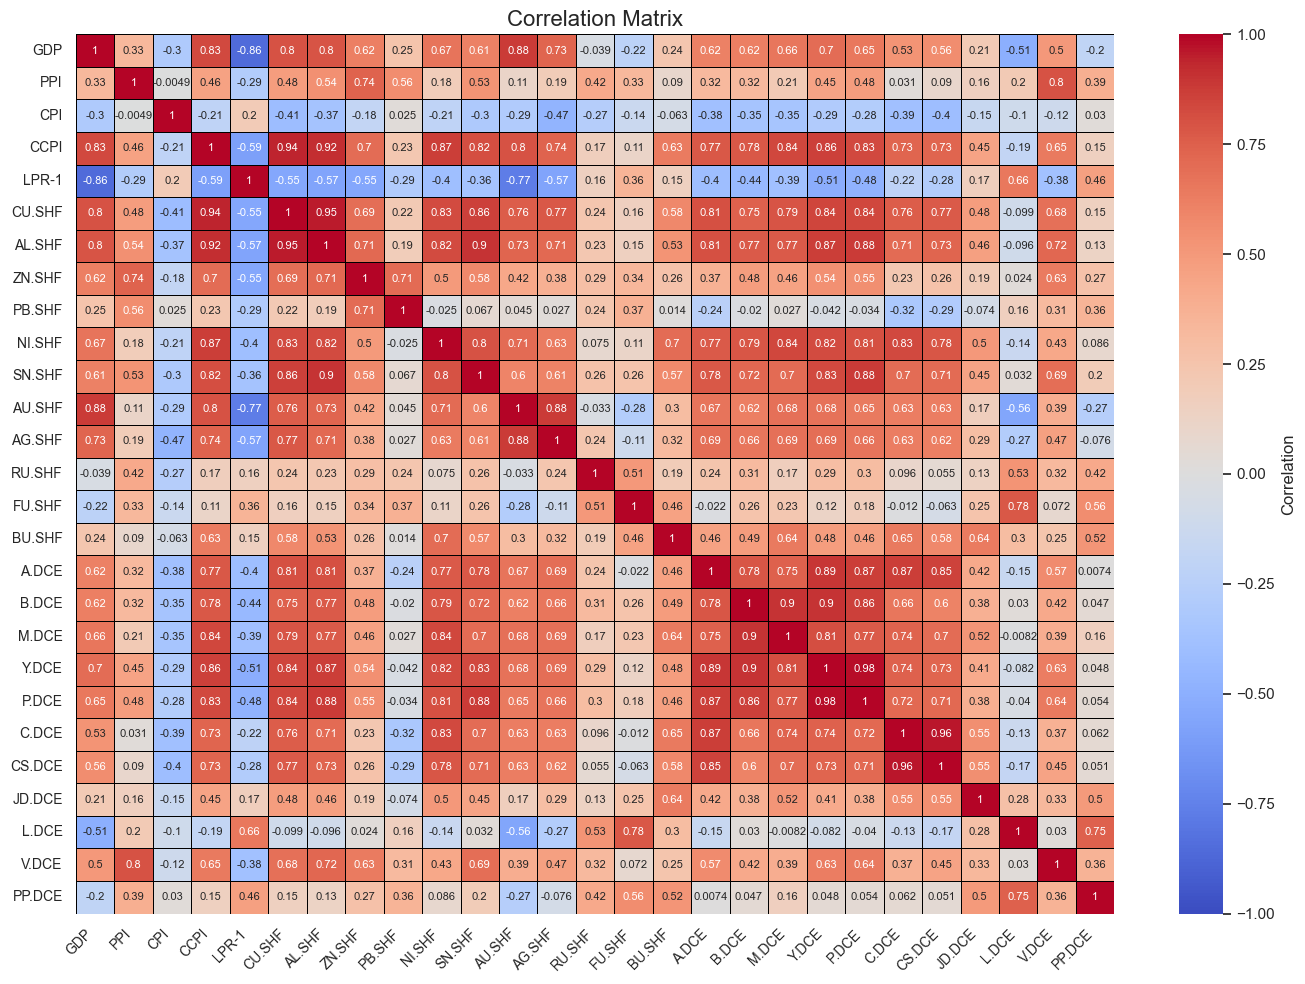

In [228]:

merged_macro = pd.merge(filled_macro_aligned, filled_price, on='Date', how='left')
merged_macro_1 = pd.merge(merged_macro, filled_foreign['000979.CSI'], on='Date', how='left')
correlation_matrix_macro = merged_macro.corr()

# Set the figure size for better visibility
plt.figure(figsize=(14, 10))

# Create a heatmap with improved settings
sns.heatmap(correlation_matrix_macro, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, vmax=1, 
            annot_kws={"size": 8},  # Adjust font size of the annotations
            cbar_kws={'label': 'Correlation'},  # Add label to the color bar
            linewidths=0.5,  # Add lines between squares
            linecolor='black'  # Color of the lines between squares
           )

# Improve the title and layout
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust y-axis labels size
plt.tight_layout()  # Adjust the layout to fit all elements properly

# Show the plot
plt.show()



In [229]:
macro_indicators = ['GDP', 'PPI', 'CPI', 'CCPI', 'LPR-1']  # Example list of macroeconomic indicators

# Set the correlation threshold
threshold = 0.5

# List to store highly correlated pairs without correlation values
highly_correlated_pairs = []

# Loop through macro indicators and commodities to find highly correlated pairs
for macro in macro_indicators:
    for commodity in correlation_matrix_macro.columns:
        if commodity not in macro_indicators and abs(correlation_matrix_macro.loc[macro, commodity]) > threshold:
            pair = (macro, commodity)  # Only include the macroeconomic indicator and commodity
            highly_correlated_pairs.append(pair)

# Convert to DataFrame for better visualization
highly_correlated_macro_df = pd.DataFrame(highly_correlated_pairs, columns=['Macroeconomic_Indicator', 'Commodity'])
print(highly_correlated_macro_df)



   Macroeconomic_Indicator Commodity
0                      GDP    CU.SHF
1                      GDP    AL.SHF
2                      GDP    ZN.SHF
3                      GDP    NI.SHF
4                      GDP    SN.SHF
5                      GDP    AU.SHF
6                      GDP    AG.SHF
7                      GDP     A.DCE
8                      GDP     B.DCE
9                      GDP     M.DCE
10                     GDP     Y.DCE
11                     GDP     P.DCE
12                     GDP     C.DCE
13                     GDP    CS.DCE
14                     GDP     L.DCE
15                     GDP     V.DCE
16                     PPI    AL.SHF
17                     PPI    ZN.SHF
18                     PPI    PB.SHF
19                     PPI    SN.SHF
20                     PPI     V.DCE
21                    CCPI    CU.SHF
22                    CCPI    AL.SHF
23                    CCPI    ZN.SHF
24                    CCPI    NI.SHF
25                    CCPI    SN.SHF
2

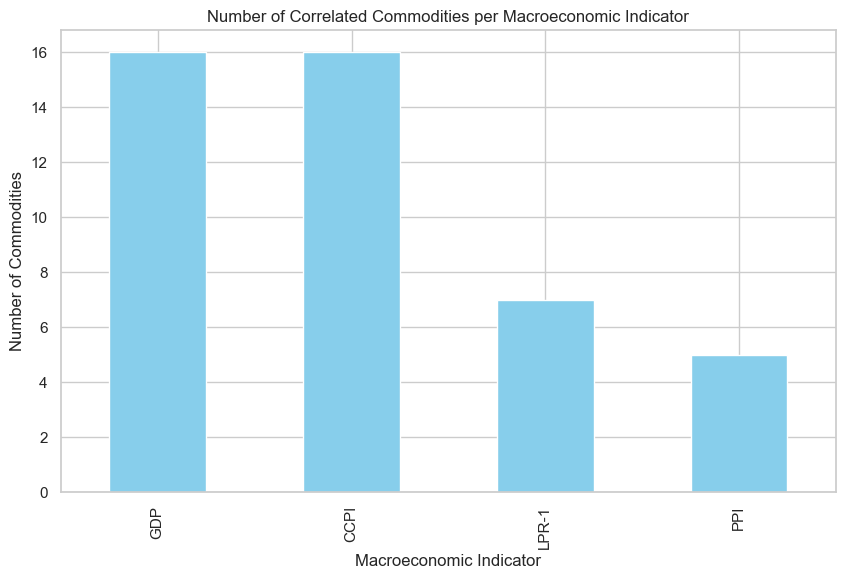

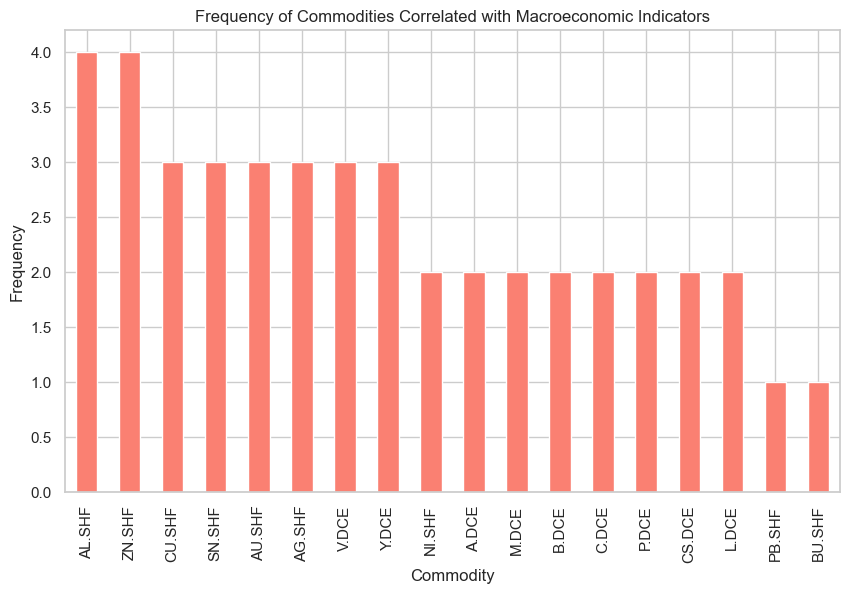

In [258]:

macro_counts = highly_correlated_macro_df['Macroeconomic_Indicator'].value_counts()

commodity_counts = highly_correlated_macro_df['Commodity'].value_counts()

# Bar plot of macroeconomic indicators
plt.figure(figsize=(10, 6))
macro_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Correlated Commodities per Macroeconomic Indicator')
plt.xlabel('Macroeconomic Indicator')
plt.ylabel('Number of Commodities')
plt.show()

# Bar plot of commodities
plt.figure(figsize=(10, 6))
commodity_counts.plot(kind='bar', color='salmon')
plt.title('Frequency of Commodities Correlated with Macroeconomic Indicators')
plt.xlabel('Commodity')
plt.ylabel('Frequency')
plt.show()




In [231]:
# Perform statistical tests for each foreign correlated pair
macro_results = []

for pair in highly_correlated_pairs:
    indicator, commodity = pair
    
    # Pearson correlation
    pearson_corr, pearson_p_value = pearsonr(merged_macro[indicator], filled_price[commodity])
    
    # Spearman correlation
    
    macro_results.append({
        'Macroeconomic_Indicator': indicator,
        'Commodity': commodity,
        'Pearson_Correlation': pearson_corr,
        'Pearson_P_value': pearson_p_value
    })

# Convert results to DataFrame
macro_results_df = pd.DataFrame(macro_results)
print(macro_results_df)
macro_results_df.to_excel('macro_results.xlsx', index=False)  # Excel



   Macroeconomic_Indicator Commodity  Pearson_Correlation  Pearson_P_value
0                      GDP    CU.SHF             0.800956     0.000000e+00
1                      GDP    AL.SHF             0.795690     0.000000e+00
2                      GDP    ZN.SHF             0.621931    1.383615e-260
3                      GDP    NI.SHF             0.665345    4.413298e-311
4                      GDP    SN.SHF             0.612202    2.444887e-250
5                      GDP    AU.SHF             0.881077     0.000000e+00
6                      GDP    AG.SHF             0.733519     0.000000e+00
7                      GDP     A.DCE             0.616762    4.261736e-255
8                      GDP     B.DCE             0.623034    9.040009e-262
9                      GDP     M.DCE             0.657817    1.012756e-301
10                     GDP     Y.DCE             0.700076     0.000000e+00
11                     GDP     P.DCE             0.652858    1.059101e-295
12                     GD

In [98]:
def standardize_prices(df):
    standardized_df = (df - df.mean()) / df.std()
    return standardized_df


In [99]:
filled_price_standardized = standardize_prices(filled_price)
num_rows = int(len(filled_price) * 0.2)
filled_price_standardized_20 = filled_price_standardized.tail(num_rows)
filled_price_standardized_20

,CU.SHF,AL.SHF,ZN.SHF,PB.SHF,NI.SHF,SN.SHF,AU.SHF,AG.SHF,RU.SHF,FU.SHF,...,B.DCE,M.DCE,Y.DCE,P.DCE,C.DCE,CS.DCE,JD.DCE,L.DCE,V.DCE,PP.DCE
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-30,1.566280,1.791996,1.093000,-0.141022,0.815440,2.525499,0.670387,0.594771,0.913627,-0.211349,...,0.776215,0.194939,1.290985,1.390267,1.116971,0.999345,0.117766,-0.089656,1.660486,-0.131098
2021-12-31,1.599710,1.764560,1.082180,-0.153527,0.858594,2.559541,0.725367,0.720978,0.931937,-0.154116,...,0.679492,0.102865,1.309587,1.438233,1.081109,1.001590,0.109682,-0.155881,1.514007,-0.151890
2022-01-04,1.540982,1.706258,1.061892,-0.111010,0.871567,2.439024,0.683639,0.583061,0.848234,-0.204535,...,0.864276,0.227677,1.332175,1.517375,1.148350,1.055474,0.164246,0.038257,1.734154,-0.015797
2022-01-05,1.575315,1.764560,1.160626,-0.203547,0.860712,2.547998,0.702811,0.581760,0.877007,-0.192271,...,0.929239,0.315659,1.418541,1.597717,1.168522,1.066699,0.073307,-0.093285,1.603093,-0.073448
2022-01-06,1.519297,1.869161,1.152511,-0.273575,0.801673,2.544672,0.668132,0.478973,0.769762,-0.212711,...,0.763222,0.156064,1.342805,1.544955,1.090074,1.012816,0.047035,-0.006195,1.603950,-0.021468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,1.482253,1.329007,0.322063,0.056557,0.297857,0.863881,2.221090,2.264086,0.434950,0.061187,...,0.956668,0.420011,0.453896,0.592845,0.552147,0.642368,-0.862364,-0.368162,-0.376517,-0.639558
2023-12-26,1.504841,1.371877,0.355876,0.069062,0.251261,0.850969,2.229548,2.316130,0.400946,0.095254,...,1.002864,0.407734,0.469840,0.620425,0.509561,0.635633,-0.868426,-0.373605,-0.415065,-0.664130
2023-12-27,1.498516,1.402743,0.359934,0.116581,0.262116,0.951335,2.246465,2.295312,0.450644,0.163387,...,1.040398,0.460933,0.534947,0.679183,0.493871,0.687271,-0.846197,-0.330060,-0.461321,-0.634832


In [233]:
filled_price_standardized

,CU.SHF,AL.SHF,ZN.SHF,PB.SHF,NI.SHF,SN.SHF,AU.SHF,AG.SHF,RU.SHF,FU.SHF,...,B.DCE,M.DCE,Y.DCE,P.DCE,C.DCE,CS.DCE,JD.DCE,L.DCE,V.DCE,PP.DCE
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,-0.000413,-0.409773,-1.305020,-0.631217,0.000000,0.000000,-1.110807,-0.146857,2.647849,2.012540,...,0.286827,0.440472,0.008777,-0.001923,0.341458,-1.020971e-15,-0.219722,2.178306,-0.148661,1.719112e-15
2014-01-03,-0.068177,-0.425206,-1.353711,-0.703746,0.000000,0.000000,-1.083317,-0.146857,2.381046,2.009814,...,0.278165,0.407734,-0.057659,-0.049889,0.321286,-1.020971e-15,-0.138887,2.155626,-0.148661,1.719112e-15
2014-01-06,-0.081729,-0.456072,-1.386172,-0.751265,0.000000,0.000000,-1.076268,-0.171578,2.182251,2.009814,...,0.286827,0.417964,-0.141368,-0.105049,0.345941,-1.020971e-15,-0.284390,2.137483,-0.144378,1.719112e-15
2014-01-07,-0.073598,-0.454357,-1.372646,-0.728756,0.000000,0.000000,-1.075563,-0.172879,1.957299,2.009814,...,0.344572,0.297245,-0.197174,-0.129031,0.379561,-1.020971e-15,-0.442019,2.042228,-0.191491,1.719112e-15
2014-01-08,-0.055527,-0.474935,-1.365884,-0.733758,0.000000,0.000000,-1.119970,-0.309495,1.915448,2.009814,...,0.327248,0.327936,-0.199831,-0.218966,0.390768,-1.020971e-15,-0.458187,2.055836,-0.187208,1.719112e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,1.482253,1.329007,0.322063,0.056557,0.297857,0.863881,2.221090,2.264086,0.434950,0.061187,...,0.956668,0.420011,0.453896,0.592845,0.552147,6.423681e-01,-0.862364,-0.368162,-0.376517,-6.395576e-01
2023-12-26,1.504841,1.371877,0.355876,0.069062,0.251261,0.850969,2.229548,2.316130,0.400946,0.095254,...,1.002864,0.407734,0.469840,0.620425,0.509561,6.356327e-01,-0.868426,-0.373605,-0.415065,-6.641300e-01
2023-12-27,1.498516,1.402743,0.359934,0.116581,0.262116,0.951335,2.246465,2.295312,0.450644,0.163387,...,1.040398,0.460933,0.534947,0.679183,0.493871,6.872709e-01,-0.846197,-0.330060,-0.461321,-6.348321e-01


In [100]:
filled_foreign_standardized = standardize_prices(filled_foreign)
num_rows = int(len(filled_foreign) * 0.2)
filled_foreign_standardized_20 = filled_foreign_standardized.tail(num_rows)
filled_foreign_standardized_20

,000979.CSI,GC.CMX,SI.CMX,HG.CMX,PL.NYM,PA.NYM
Date,,,,,,
2021-12-30,1.674267,1.079762,1.005551,1.820928,-0.248209,0.928395
2021-12-31,1.710910,1.130235,1.078698,1.924154,-0.229381,0.836807
2022-01-04,1.760947,1.077743,1.009470,1.939207,-0.190510,0.794066
2022-01-05,1.684884,1.063274,0.938935,1.826663,-0.120056,0.782617
2022-01-06,1.715886,0.996985,0.776966,1.772900,-0.231203,0.793303
...,...,...,...,...,...,...
2023-12-25,0.305729,1.917625,1.369981,1.123441,-0.143743,-0.209588
2023-12-26,0.287123,1.967089,1.377818,1.124875,-0.112160,-0.250803
2023-12-27,0.313189,2.001411,1.389574,1.200143,0.074300,-0.291255


In [101]:
filled_macro_standardized = standardize_prices(filled_macro_aligned)
num_rows = int(len(filled_macro_aligned) * 0.2)
filled_macro_standardized_20 = filled_macro_standardized.tail(num_rows)
filled_macro_standardized_20

,GDP,PPI,CPI,CCPI,LPR-1
Date,,,,,
2021-12-30,1.580942,2.016521,-0.248679,1.077589,-0.774523
2021-12-31,1.580942,2.016521,-0.248679,1.077589,-0.774523
2022-01-04,0.779250,1.760347,-0.817418,1.336625,-0.774523
2022-01-05,0.779250,1.760347,-0.817418,1.336625,-0.774523
2022-01-06,0.779250,1.760347,-0.817418,1.336625,-0.774523
...,...,...,...,...,...
2023-12-25,2.045066,-0.758697,-1.954897,1.193164,-1.334949
2023-12-26,2.045066,-0.758697,-1.954897,1.193164,-1.334949
2023-12-27,2.045066,-0.758697,-1.954897,1.193164,-1.334949


In [102]:

def merge_prices_with_foreign(prices_df, correlation_df, factor_df):
    final_df = pd.DataFrame()

    for col_name in prices_df.columns:
        final_df[col_name] = prices_df[col_name]
        if col_name in correlation_df['Commodity'].values:
            related_correlation = correlation_df[correlation_df['Commodity'] == col_name]
            related_factors = related_correlation['Foreign_Commodity'].values
            for factor in related_factors:
                final_df[col_name] += factor_df[factor] * related_correlation[related_correlation['Foreign_Commodity'] == factor]['Pearson_Correlation'].values

    return final_df


In [103]:
price_foreign = merge_prices_with_foreign(filled_price_standardized_20, foreign_results_df, filled_foreign_standardized_20)
price_all = merge_prices_with_foreign(filled_price_standardized, foreign_results_df, filled_foreign_standardized)

In [104]:

def merge_prices_with_macro(prices_df, correlation_df, factor_df):
    final_df = pd.DataFrame()

    for col_name in prices_df.columns:
        final_df[col_name] = prices_df[col_name]
        if col_name in correlation_df['Commodity'].values:
            related_correlation = correlation_df[correlation_df['Commodity'] == col_name]
            related_factors = related_correlation['Macroeconomic_Indicator'].values
            for factor in related_factors:
                final_df[col_name] += factor_df[factor] * related_correlation[related_correlation['Macroeconomic_Indicator'] == factor]['Pearson_Correlation'].values

    return final_df


In [105]:
price_merged = merge_prices_with_macro(price_foreign, macro_results_df, filled_macro_standardized_20)
price_all = merge_prices_with_macro(price_all, macro_results_df, filled_macro_standardized)


In [234]:
pair_value_zscore_merged = {}

for pair in pairs_coint:
    port_value_list = []
    count_1 = 0
    count_2 = 0
    port_value = 0
    _, signal_list, date_list = trade(price_merged[pair[0]], price_merged[pair[1]], 21, 5)
    for j in range(0, len(filled_price_20)):
        if j not in date_list:
            if j == 0:
                port_value_list.append(0)
            else:
                port_value_list.append(port_value_list[-1])
        else:
            for i in range(0, len(date_list)):
                if j == date_list[i]:
                    price_1 = filled_price_20[pair[0]].iloc[date_list[i]]
                    price_2 = filled_price_20[pair[1]].iloc[date_list[i]]
                    ratio = price_1/price_2
                    if signal_list[i] == 'Long':
                        port_value += price_1 - ratio * price_2
                        port_value_list.append(port_value)
                        count_1 -= 1
                        count_2 += ratio
                    elif signal_list[i] == 'Short':
                        port_value += ratio * price_2 - price_1
                        port_value_list.append(port_value)
                        count_1 += 1
                        count_2 -= ratio
                    elif signal_list[i] == 'Exit':
                        port_value += price_1 * count_1 + price_2 * count_2
                        port_value_list.append(port_value)
                        count_1 = 0
                        count_2 = 0
            
    pair_name = f"{pair[0]}_vs_{pair[1]}"

    pair_value_zscore_merged[pair_name] = port_value_list
    pair_value_zscore_merged_df = pd.DataFrame(pair_value_zscore_merged)



pair_value_zscore_merged_df

,CU.SHF_vs_AL.SHF,AL.SHF_vs_SN.SHF,AL.SHF_vs_M.DCE,AL.SHF_vs_P.DCE,NI.SHF_vs_M.DCE,SN.SHF_vs_P.DCE,RU.SHF_vs_FU.SHF,RU.SHF_vs_BU.SHF,RU.SHF_vs_A.DCE,RU.SHF_vs_B.DCE,...,B.DCE_vs_P.DCE,M.DCE_vs_Y.DCE,M.DCE_vs_P.DCE,M.DCE_vs_C.DCE,M.DCE_vs_CS.DCE,Y.DCE_vs_P.DCE,C.DCE_vs_CS.DCE,JD.DCE_vs_L.DCE,JD.DCE_vs_V.DCE,JD.DCE_vs_PP.DCE
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,-8736.809581,-4425.064496,6569.61438,2613.489182,107857.404902,-31710.069488,7423.389972,3082.060484,294.355897,1692.293691,...,1200.535502,2053.609452,2245.770864,1760.808305,1839.586399,2824.264142,40.862451,492.06917,-1093.340851,261.527419
482,-8736.809581,-3780.340851,6569.61438,2613.489182,107857.404902,-31710.069488,7423.389972,3082.060484,294.355897,1692.293691,...,1200.535502,2053.609452,2245.770864,1760.808305,1839.586399,2824.264142,40.862451,492.06917,-1093.340851,261.527419
483,-8736.809581,-3780.340851,6569.61438,2613.489182,107857.404902,-31710.069488,7423.389972,3082.060484,294.355897,1692.293691,...,1200.535502,2053.609452,2245.770864,1760.808305,1839.586399,2824.264142,40.862451,492.06917,-1093.340851,261.527419
484,-8736.809581,-3780.340851,6569.61438,2613.489182,107857.404902,-31710.069488,7423.389972,3082.060484,294.355897,1692.293691,...,1271.169431,2053.609452,2245.770864,1760.808305,1839.586399,2824.264142,53.455070,492.06917,-1093.340851,261.527419


In [259]:
# Calculate weighted portfolio value
portfolio_values_zscore_merged = calculate_weighted_portfolio_value(pair_value_zscore_merged_df)

# Calculate annualized return
annualized_return_zscore_merged = annualized_return(portfolio_values_zscore_merged, 10)

# Calculate percentage returns, handling NaN values
portfolio_returns_zscore_merged = calculate_percentage_returns(portfolio_values_zscore_merged)

# Drop NaN values before calculating volatility
portfolio_returns_zscore_merged = portfolio_returns_zscore_merged.dropna()

# Calculate volatility
volatility_zscore_merged = np.std(portfolio_returns_zscore_merged)

sp_zscore_merged = calculate_sharpe_ratio(portfolio_returns_zscore_merged)

print(f"Portfolio Annualized return: {annualized_return_zscore_merged}")
print(f"Volatility: {volatility_zscore_merged}")
print(f"Sharpe Ratio: {sp_zscore_merged}")




Portfolio Annualized return: 0.8641571582135539
Volatility: 1.6108892275894362
Sharpe Ratio: -0.04198520665427431


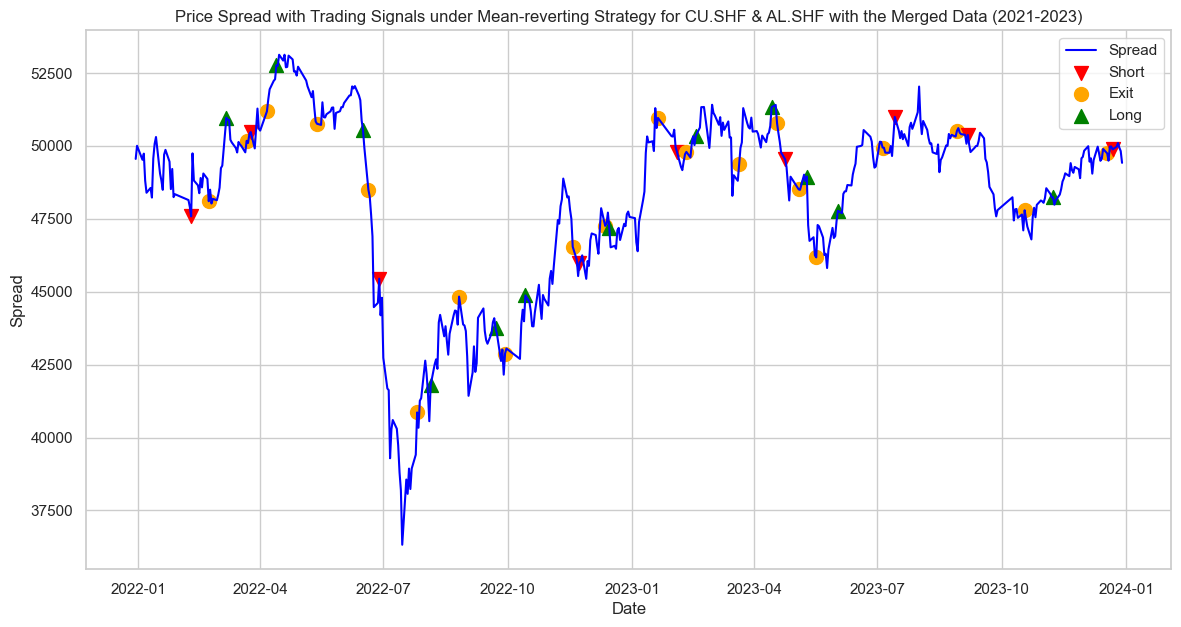

In [248]:
_, signal_zscore, date_list = trade(price_merged['CU.SHF'], price_merged['AL.SHF'], 21, 5)
# Full price spread data (replace with your actual data)
full_spread_data = filled_price_20['CU.SHF'] - filled_price_20['AL.SHF']
full_date_list = full_spread_data.index

# Signal data (subset of full data where signals occur)
signal_dates = filled_price_20.iloc[date_list].index
signals = signal_zscore
signal_spread = full_spread_data.loc[signal_dates]

# Plot the full spread with signals marked
plot_spread_with_signals(full_date_list, full_spread_data, signal_dates, signal_spread, signals, 'CU.SHF & AL.SHF with the Merged Data')


In [115]:

def pair_trading_merged(prices_asset1, prices_asset2, lookback=21, kernel='linear', train_size_ratio=0.8):
    # Calculate the spread between the two assets
    spread = calculate_spread(prices_asset1, prices_asset2)
    
    # Generate features based on the spread
    X, y = generate_features(spread, lookback)
    
    # Drop NaN values
    valid_indices = ~np.isnan(y)
    X, y = X[valid_indices], y[valid_indices]
    
    # Get the corresponding dates for the signals
    dates = spread.index[lookback:][valid_indices]
    
    # Split the data into training and testing sets
    train_size = int(train_size_ratio * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    dates_test = dates[train_size:]  # Corresponding dates for the test set
    
    # Normalize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train the SVM model
    svm = train_svm(X_train, y_train, kernel)
    
    # Predict trading signals using the SVM model
    signals = predict_signals(svm, X_test)
    
    # Calculate the strategy returns based on the signals
    strategy_returns = calculate_returns(signals, prices_asset1, prices_asset2, lookback, train_size)
    
    return strategy_returns, signals, dates_test


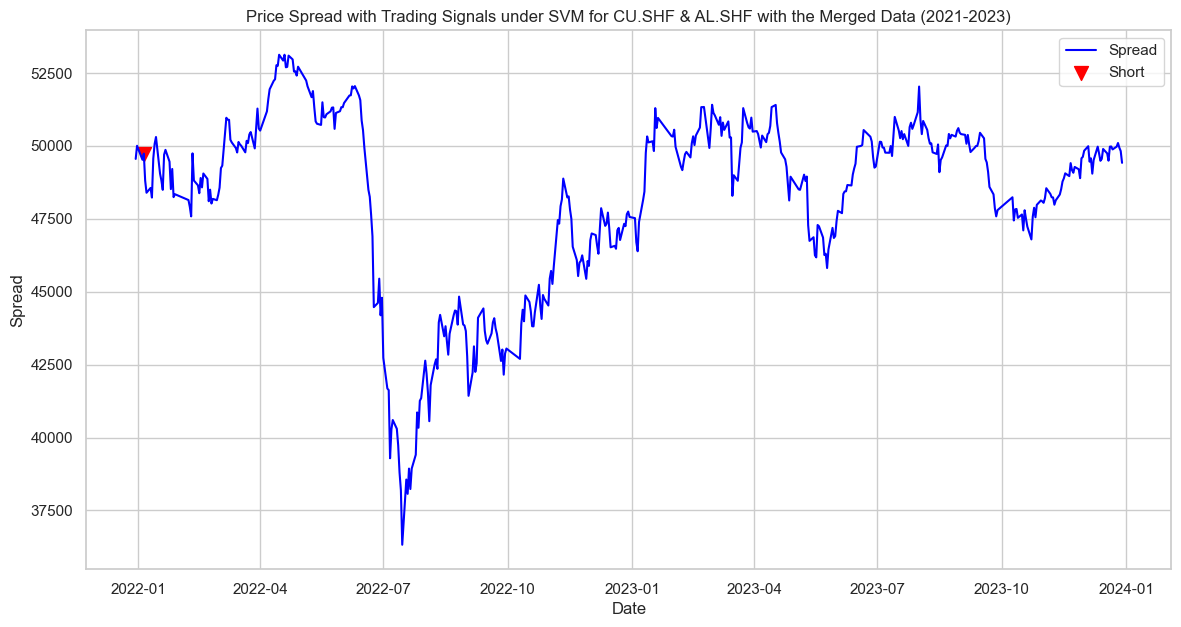

In [250]:
_, signal_list, date_list = pair_trading_merged(price_all['CU.SHF'], price_all['AL.SHF'], lookback=21, kernel='linear', train_size_ratio=0.8)

# Full price spread data (replace with your actual data)
full_spread_data = filled_price_20['CU.SHF'] - filled_price_20['AL.SHF']
full_date_list = full_spread_data.index

# Signal data (subset of full data where signals occur)
relevant_rows = filled_price_20.loc[filled_price_20.index.isin(date_list)]
signal_dates = relevant_rows.index
signals = signal_list
signal_spread = full_spread_data.loc[signal_dates]

# Plot the full spread with signals marked
plot_spread_with_signals_svm(full_date_list, full_spread_data, signal_dates, signal_spread, signals, 'CU.SHF & AL.SHF with the Merged Data')



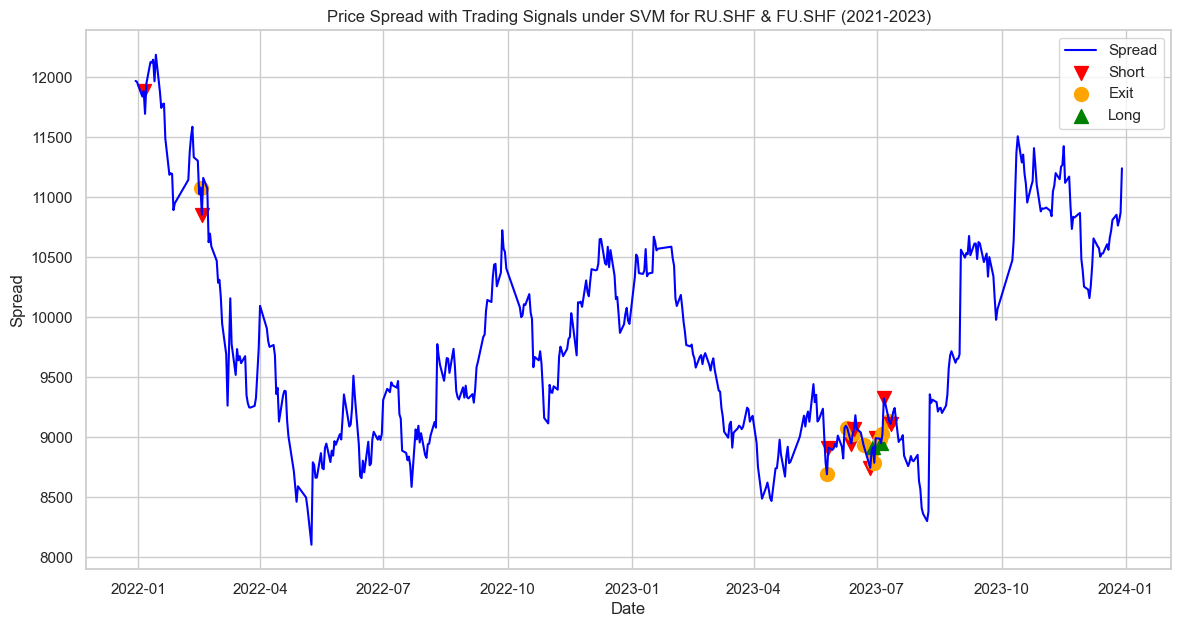

In [251]:
_, signal_list, date_list = pair_trading_merged(price_all['RU.SHF'], price_all['FU.SHF'], lookback=21, kernel='linear', train_size_ratio=0.8)

# Full price spread data (replace with your actual data)
full_spread_data = filled_price_20['RU.SHF'] - filled_price_20['FU.SHF']
full_date_list = full_spread_data.index

# Signal data (subset of full data where signals occur)
relevant_rows = filled_price_20.loc[filled_price_20.index.isin(date_list)]
signal_dates = relevant_rows.index
signals = signal_list
signal_spread = full_spread_data.loc[signal_dates]

# Plot the full spread with signals marked
plot_spread_with_signals_svm(full_date_list, full_spread_data, signal_dates, signal_spread, signals, 'RU.SHF & FU.SHF')


In [117]:
returns_list_svm = {}
for pair in pairs_coint:
    port_value_list = []
    count_1 = 0
    count_2 = 0
    port_value = 0
    dates = filled_price.index.strftime('%Y-%m-%d')
    _, signal_list, date_list = pair_trading_merged(price_all[pair[0]], price_all[pair[1]], lookback=21, kernel='linear', train_size_ratio=0.8)


    for j in range(0, len(dates)):
            if dates[j] not in date_list:
                if j == 0:
                    port_value_list.append(0)
                else:
                    port_value_list.append(port_value_list[-1])
            else:
                for i in range(0, len(date_list)):
                    signal_date = date_list[i].date()
                    signal_date = signal_date.strftime('%Y-%m-%d')
                    if dates[j] == signal_date: 
                        price_1 = filled_price[pair[0]].iloc[j]
                        price_2 = filled_price[pair[1]].iloc[j]
                        ratio = price_1/price_2
                        if signal_list[i] == 1:
                            port_value += price_1 - ratio * price_2
                            port_value_list.append(port_value)
                            count_1 -= 1
                            count_2 += ratio
                        elif signal_list[i] == -1:
                            port_value += ratio * price_2 - price_1
                            port_value_list.append(port_value)
                            count_1 += 1
                            count_2 -= ratio
                        elif signal_list[i] == 3:
                            port_value += price_1 * count_1 + price_2 * count_2
                            port_value_list.append(port_value)
                            count_1 = 0
                            count_2 = 0
                        elif signal_list[i] == 2:
                            port_value_list.append(port_value_list[-1])
    pair_name = f"{pair[0]}_vs_{pair[1]}"
    returns_list_svm[pair_name] = port_value_list
    pair_return_svm_merged_df = pd.DataFrame(returns_list_svm)

pair_return_svm_merged_df


,CU.SHF_vs_AL.SHF,AL.SHF_vs_SN.SHF,AL.SHF_vs_M.DCE,AL.SHF_vs_P.DCE,NI.SHF_vs_M.DCE,SN.SHF_vs_P.DCE,RU.SHF_vs_FU.SHF,RU.SHF_vs_BU.SHF,RU.SHF_vs_A.DCE,RU.SHF_vs_B.DCE,...,B.DCE_vs_P.DCE,M.DCE_vs_Y.DCE,M.DCE_vs_P.DCE,M.DCE_vs_C.DCE,M.DCE_vs_CS.DCE,Y.DCE_vs_P.DCE,C.DCE_vs_CS.DCE,JD.DCE_vs_L.DCE,JD.DCE_vs_V.DCE,JD.DCE_vs_PP.DCE
0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
1,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
2,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
3,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
4,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,0.0,3.637979e-12,0.0,0.0,0.0,0.0,-3757.732217,0.0,1.818989e-12,0.0,...,0.0,0.0,-4.547474e-13,0.0,-289.727468,1.818989e-12,0.0,0.0,0.0,0.0
2430,0.0,3.637979e-12,0.0,0.0,0.0,0.0,-3757.732217,0.0,1.818989e-12,0.0,...,0.0,0.0,-4.547474e-13,0.0,-289.727468,1.818989e-12,0.0,0.0,0.0,0.0
2431,0.0,3.637979e-12,0.0,0.0,0.0,0.0,-3757.732217,0.0,1.818989e-12,0.0,...,0.0,0.0,-4.547474e-13,0.0,-289.727468,1.818989e-12,0.0,0.0,0.0,0.0
2432,0.0,3.637979e-12,0.0,0.0,0.0,0.0,-3757.732217,0.0,1.818989e-12,0.0,...,0.0,0.0,-4.547474e-13,0.0,-289.727468,1.818989e-12,0.0,0.0,0.0,0.0


In [118]:
num_rows = int(len(pair_return_svm_merged_df) * 0.2)
return_svm_merged_df = pair_return_svm_merged_df.tail(num_rows)
return_svm_merged_df


,CU.SHF_vs_AL.SHF,AL.SHF_vs_SN.SHF,AL.SHF_vs_M.DCE,AL.SHF_vs_P.DCE,NI.SHF_vs_M.DCE,SN.SHF_vs_P.DCE,RU.SHF_vs_FU.SHF,RU.SHF_vs_BU.SHF,RU.SHF_vs_A.DCE,RU.SHF_vs_B.DCE,...,B.DCE_vs_P.DCE,M.DCE_vs_Y.DCE,M.DCE_vs_P.DCE,M.DCE_vs_C.DCE,M.DCE_vs_CS.DCE,Y.DCE_vs_P.DCE,C.DCE_vs_CS.DCE,JD.DCE_vs_L.DCE,JD.DCE_vs_V.DCE,JD.DCE_vs_PP.DCE
1948,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
1949,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
1950,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
1951,0.0,3.637979e-12,0.0,0.0,0.0,0.0,0.000000,0.0,1.818989e-12,0.0,...,0.0,0.0,-4.547474e-13,0.0,0.000000,1.818989e-12,0.0,0.0,0.0,0.0
1952,0.0,3.637979e-12,0.0,0.0,0.0,0.0,0.000000,0.0,1.818989e-12,0.0,...,0.0,0.0,-4.547474e-13,0.0,0.000000,1.818989e-12,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,0.0,3.637979e-12,0.0,0.0,0.0,0.0,-3757.732217,0.0,1.818989e-12,0.0,...,0.0,0.0,-4.547474e-13,0.0,-289.727468,1.818989e-12,0.0,0.0,0.0,0.0
2430,0.0,3.637979e-12,0.0,0.0,0.0,0.0,-3757.732217,0.0,1.818989e-12,0.0,...,0.0,0.0,-4.547474e-13,0.0,-289.727468,1.818989e-12,0.0,0.0,0.0,0.0
2431,0.0,3.637979e-12,0.0,0.0,0.0,0.0,-3757.732217,0.0,1.818989e-12,0.0,...,0.0,0.0,-4.547474e-13,0.0,-289.727468,1.818989e-12,0.0,0.0,0.0,0.0
2432,0.0,3.637979e-12,0.0,0.0,0.0,0.0,-3757.732217,0.0,1.818989e-12,0.0,...,0.0,0.0,-4.547474e-13,0.0,-289.727468,1.818989e-12,0.0,0.0,0.0,0.0


In [260]:
# Calculate weighted portfolio value
portfolio_returns_svm_merged = calculate_weighted_portfolio_value(return_svm_merged_df)

# Calculate annualized return
annualized_return_svm_merged = annualized_return(portfolio_returns_svm_merged,2)

# Drop NaN values before calculating volatility
portfolio_returns_svm_merged = portfolio_returns_svm_merged.dropna()

# Calculate volatility, Sharpe Ratio, and Maximum drawdown
volatility_svm_merged = np.std(portfolio_returns_svm_merged)
sp_svm_merged = calculate_sharpe_ratio(portfolio_returns_svm_merged)

print(f"Portfolio Annualized return: {annualized_return_svm_merged}")
print(f"Volatility: {volatility_svm_merged}")
print(f"Sharpe Ratio: {sp_svm_merged}")


Portfolio Annualized return: -0.3530285996363971
Volatility: 30.151257401756403
Sharpe Ratio: -2.3962060279044377


Selected trading pair: CU.SHF and AL.SHF
spread_normalized_trade min value: -0.527, max value: 1.100, Stop loss point with RL: 0.567, Stop earning porint with RL: 0.079, Entry point with RL: 0.323


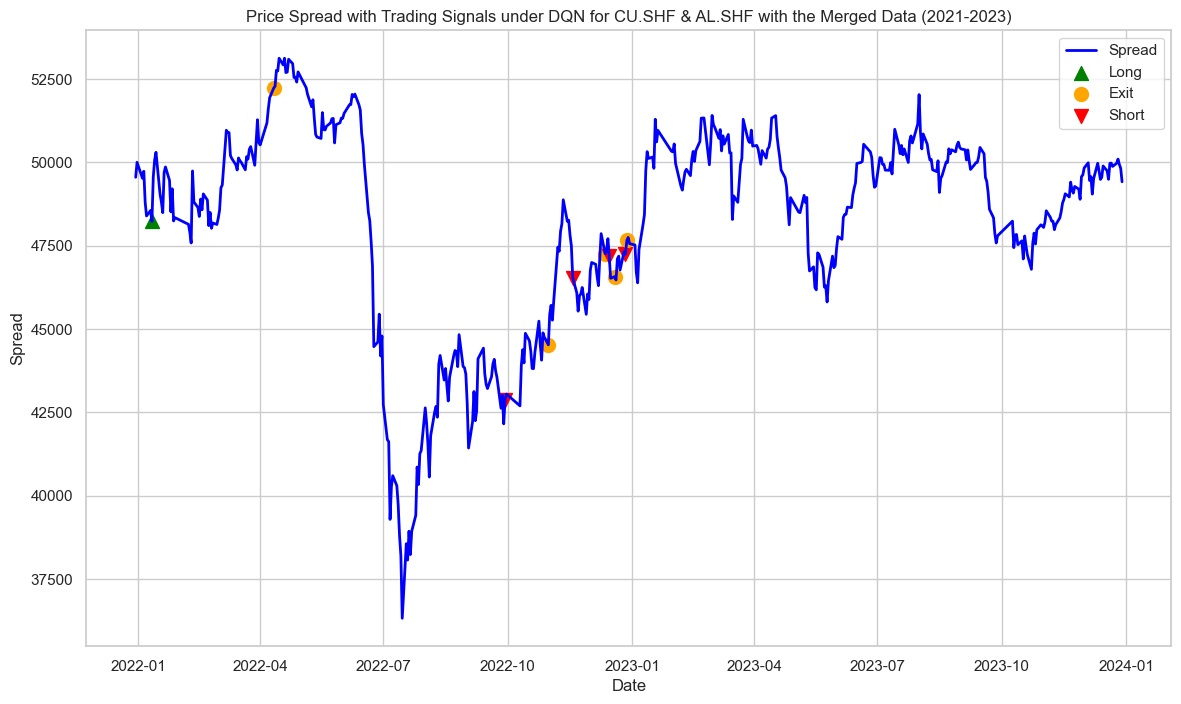

In [252]:
strategy = PairTradingStrategy(price_all, pairs_coint, num=0)
trades_df = strategy.pair_strategy()
trades_df
full_spread_data = filled_price_20['CU.SHF'] - filled_price_20['AL.SHF']
plot_trading_actions_rl(trades_df, full_spread_data, 'CU.SHF & AL.SHF with the Merged Data')

In [122]:
import pandas as pd

if __name__ == "__main__":

    returns_rl_merged = {}

    for n in range(0, len(pairs_coint)):
        port_value_list = []
        port_value = 0
        dates = filled_price_20.index
        pair = pairs_coint[n]
        # Initialize the PairTradingStrategy with the price data and selected pair
        strategy = PairTradingStrategy(price_all, pairs_coint, n)
        # Execute the trading strategy
        trades_df = strategy.pair_strategy()
        count_1 = 0
        count_2 = 0


        for j in range(0, len(dates)):
            if dates[j] not in trades_df['trade_date'].values:
                if j == 0:
                    port_value_list.append(0)
                else:
                    port_value_list.append(port_value_list[-1])
   
            else:
                for i in range(0, len(trades_df)):
                    signal_date = trades_df['trade_date'][i]
                    if dates[j] == signal_date: 
                        price_1 = filled_price[pair[0]][signal_date]
                        price_2 = filled_price[pair[1]][signal_date]
                        ratio = price_1/price_2
                        if trades_df['action'][i] == 'Long/Short':
                            port_value += price_1 - ratio * price_2 
                            port_value_list.append(port_value)
                            count_1 -= 1
                            count_2 += ratio
                            
                        elif trades_df['action'][i] == 'Short/Long':
                            port_value += ratio * price_2 - price_1
                            port_value_list.append(port_value)
                            count_1 += 1
                            count_2 -= ratio
                        elif trades_df['action'][i] == 'Exit':
                            port_value += count_1 * price_1 + count_2 * price_2
                            port_value_list.append(port_value)
                            count_1 = 0
                            count_2 = 0


        pair_name = f"{pair[0]}_vs_{pair[1]}"
        returns_rl_merged[pair_name] = port_value_list
        return_rl_merged_df = pd.DataFrame(returns_rl_merged)

return_rl_merged_df


Selected trading pair: CU.SHF and AL.SHF
spread_normalized_trade min value: -0.527, max value: 1.100, Stop loss point with RL: 0.476, Stop earning porint with RL: -0.011, Entry point with RL: 0.232
Selected trading pair: AL.SHF and SN.SHF
spread_normalized_trade min value: 0.030, max value: 0.980, Stop loss point with RL: 0.695, Stop earning porint with RL: 0.410, Entry point with RL: 0.553
Selected trading pair: AL.SHF and M.DCE
spread_normalized_trade min value: -0.203, max value: 0.801, Stop loss point with RL: 0.405, Stop earning porint with RL: 0.104, Entry point with RL: 0.254
Selected trading pair: AL.SHF and P.DCE
spread_normalized_trade min value: -0.090, max value: 0.642, Stop loss point with RL: 0.424, Stop earning porint with RL: 0.204, Entry point with RL: 0.314
Selected trading pair: NI.SHF and M.DCE
spread_normalized_trade min value: -0.452, max value: 1.580, Stop loss point with RL: 0.766, Stop earning porint with RL: 0.157, Entry point with RL: 0.462
Selected trading p

,CU.SHF_vs_AL.SHF,AL.SHF_vs_SN.SHF,AL.SHF_vs_M.DCE,AL.SHF_vs_P.DCE,NI.SHF_vs_M.DCE,SN.SHF_vs_P.DCE,RU.SHF_vs_FU.SHF,RU.SHF_vs_BU.SHF,RU.SHF_vs_A.DCE,RU.SHF_vs_B.DCE,...,B.DCE_vs_P.DCE,M.DCE_vs_Y.DCE,M.DCE_vs_P.DCE,M.DCE_vs_C.DCE,M.DCE_vs_CS.DCE,Y.DCE_vs_P.DCE,C.DCE_vs_CS.DCE,JD.DCE_vs_L.DCE,JD.DCE_vs_V.DCE,JD.DCE_vs_PP.DCE
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.818989e-12,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.818989e-12,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,-2098.307733,8413.79965,-2928.488372,-7960.657069,44504.194774,89727.300109,1933.240243,-642.387125,2.427884e+03,4913.407695,...,2510.693613,307.270022,2602.356938,-165.890811,810.773115,276.45111,280.960875,453.791134,1014.627672,574.212445
482,-2098.307733,8413.79965,-2928.488372,-7960.657069,44504.194774,89727.300109,1933.240243,-642.387125,2.427884e+03,4913.407695,...,2510.693613,307.270022,2602.356938,-165.890811,810.773115,276.45111,280.960875,453.791134,1014.627672,574.212445
483,-2098.307733,8413.79965,-2928.488372,-7960.657069,44504.194774,89727.300109,1933.240243,-642.387125,2.427884e+03,4913.407695,...,2510.693613,307.270022,2602.356938,-165.890811,810.773115,276.45111,280.960875,453.791134,1014.627672,574.212445
484,-2098.307733,8413.79965,-2928.488372,-7960.657069,44504.194774,89727.300109,1933.240243,-642.387125,2.427884e+03,4913.407695,...,2510.693613,307.270022,2602.356938,-165.890811,810.773115,276.45111,280.960875,453.791134,1014.627672,574.212445


In [261]:
# Calculate weighted portfolio value
portfolio_values_rl_merged = calculate_weighted_portfolio_value(return_rl_merged_df)

# Calculate annualized return
annualized_return_rl_merged = annualized_return(portfolio_values_rl_merged, 2)

# Calculate percentage returns, handling NaN values
portfolio_returns_rl_merged = calculate_percentage_returns(portfolio_values_rl_merged)

# Drop NaN values before calculating volatility
portfolio_returns_rl_merged = portfolio_returns_rl_merged.dropna()

# Calculate volatility
volatility_rl_merged = np.std(portfolio_returns_rl_merged)

sp_rl_merged = calculate_sharpe_ratio(portfolio_returns_rl_merged)

print(f"Portfolio Annualized return: {annualized_return_rl_merged}")
print(f"Volatility: {volatility_rl_merged}")
print(f"Sharpe Ratio: {sp_rl_merged}")




Portfolio Annualized return: 15.2974177476407
Volatility: 0.9509242916053392
Sharpe Ratio: -0.02187503689897448


In [262]:
# Assuming you have already calculated these values for both models
zscore_svm_performance = {
    'Metric (only commodity prices)': ['Portfolio Annualized Return', 'Volatility', 'Sharpe Ratio'],
    'Z-Score Model': [annualized_return_zscore, volatility_zscore, sp_zscore],
    'SVM Model': [annualized_return_svm, volatility_svm, sp_svm],
    'RL Model': [annualized_return_rl, volatility_rl, sp_rl]
}

# Create the DataFrame
zscore_svm_performance_df = pd.DataFrame(zscore_svm_performance)

# Display the DataFrame
print(zscore_svm_performance_df)


  Metric (only commodity prices)  Z-Score Model  SVM Model  RL Model
0    Portfolio Annualized Return       0.927285   0.052510 -6.606298
1                     Volatility       0.363274   0.011494  1.869578
2                   Sharpe Ratio       0.027112  -1.855916  0.055226


In [241]:
# Assuming you have already calculated these values for both models
zscore_svm_performance_factor = {
    'Metric (with merged features)': ['Portfolio Annualized Return', 'Volatility', 'Sharpe Ratio'],
    'Z-Score Model': [annualized_return_zscore_merged, volatility_zscore_merged, sp_zscore_merged],
    'SVM Model': [annualized_return_svm_merged, volatility_svm_merged, sp_svm_merged],
    'RL Model': [annualized_return_rl_merged, volatility_rl_merged, sp_rl_merged]
}

# Create the DataFrame
zscore_svm_performance_factor_df = pd.DataFrame(zscore_svm_performance_factor)

# Display the DataFrame
print(zscore_svm_performance_factor_df)


  Metric (with merged features)  Z-Score Model  SVM Model   RL Model
0   Portfolio Annualized Return       0.864157  -0.353029  15.297418
1                    Volatility       1.610889  30.151257   0.950924
2                  Sharpe Ratio      -0.041985  -2.396206  -0.021875
